<a href="https://www.kaggle.com/code/vladosht/simple-stock-pricing-model?scriptVersionId=268853045" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook will present a model which attempts to make individual estimates whether a stock is overvalued or not. It is based on the fundamental financial data of 3000+ public companies, which report to the SEC and which are currently traded on US stock exchanges.

DISCLAIMER: The results of this model must not in any way be interpreted as financial advice. It is intended for research purposes only and no investment decisions must be taken based on it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import multiprocessing as mp
import json
pd.set_option('display.max_rows', 200)
# Workaround for a pandas bug, as described here:
# https://stackoverflow.com/questions/30519487/pandas-error-invalid-value-encountered
pd.set_option('display.float_format', lambda x:'%f'%x)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch threads:',torch.get_num_threads())
print(torch.ones(1, device=device),device)

Torch threads: 2
tensor([1.], device='cuda:0') cuda


In [3]:
if __name__ == '__main__':
    mp.set_start_method('fork')
print('{} CPUs available'.format(mp.cpu_count()))
max_jobs = mp.cpu_count() + 1

4 CPUs available


The model will be based on the following features and labels, taken from the SEC fundamental dataset:

In [4]:
ml_features = ['Assets','Liabilities','NetCashOperating_ttm']
ml_label = 'price'
keys = ['snapshot','cik','date']
window_size = 12*3 #in number of snapshots

The model is called "simple", because it is rooted in this very basic assumption:  
Market_Capitalization = ( Assets \* asset_multiplier - Liabilities + NetCashOperating_ttm \* cash_multiplier ) \* hype + bias  
The business logic behind this formula is that the market capitalization of a company is dependent on its current static value (its equity) and its future cashflows. The following considerations apply:  
1. We assume the total assets of an individual company should never be taken at the nominal value that appears on the balance sheet, because they often contain significant amount of "intangible" assets, for which it is notoriously difficult to arrive at a fair value. Therefore, we discount them with an asset_multiplier.
2. The Liabilities, on the other hand, can be taken at nominal value, because it is a rare event for any kind of debt, accounts payable or the like, to be written off.
3. Then, the cash flows from operating activities can be modeled as a [perpetuity](https://en.wikipedia.org/wiki/Perpetuity). This is inspired by the idea for a [Steady State Cash Flow Model](https://www.google.com/search?q=%22Steady+State+Cash+Flow+Model%22) where we attempt to estimate the fair value of a company on the assumption that its business behaves the same way for the foreseeable future. In essence, we again discount the NetCashOperating_ttm with a cash_multiplier. We use the Trailing Twelve Months (ttm) value here, and not the quarterly value, because it smoothens any seasonalities and makes the model less erratic.
4. All of the above is multiplied by a "hype" parameter, which is the premium or penalty that the market gives to the total value of the company.
5. The bias further fine-tunes the company value to its market capitalization.  

However, it seems difficult to obtain freely available historic market capitalization data for individual companies. It turns out this is not really necessary. It is much easier to obtain historic prices and modelling the share price directly is even simpler.  
We do this by maximizing the **correlation coefficient** between our formula and the price. In short, we try to find such asset_multiplier and cash_multiplier parameters, for which the correlation between ( Assets \* asset_multiplier - Liabilities + NetCashOperating_ttm \* cash_multiplier ) and the price is equal to 1.

In [5]:
# We use this dataset to provide ticker descriptions later on.
with open('/kaggle/input/sec-edgar-cik-ticker-exchange/company_tickers_exchange.json',mode='rt') as f:
    jfile = json.load(f)
tickers = pd.DataFrame(columns=jfile['fields'],data=jfile['data'],dtype=str)
tickers = tickers[tickers['exchange']!='OTC'].dropna() #leave only tickers traded on an exchange
tickers['exchange'] = tickers['exchange'].str.upper().str.strip()
tickers['cik'] = tickers['cik'].str.zfill(10)
tickers['len'] = 4
tickers.loc[tickers[tickers['ticker'].str.contains('-')].index,'len'] += 1
tickers['ticker'] = tickers.apply(lambda row: str(row.ticker[:row.len]),axis='columns').str.rstrip().str.rstrip('-').str.upper()
tickers = tickers.sort_values(by=['cik','exchange','ticker']).drop_duplicates(subset=['cik'],keep='last').set_index('cik').drop(columns=['len'])
tickers

name ticker exchange
cik                                                        
0000001750                         AAR CORP    AIR     NYSE
0000001800              ABBOTT LABORATORIES    ABT     NYSE
0000002098                 ACME UNITED CORP    ACU     NYSE
0000002178   ADAMS RESOURCES & ENERGY, INC.     AE     NYSE
0000002186             BK Technologies Corp   BKTI     NYSE
...                                     ...    ...      ...
0001984060      Atlas Energy Solutions Inc.   AESI     NYSE
0001990550            Ambrx Biopharma, Inc.   AMAM   NASDAQ
0001993004  NorthWestern Energy Group, Inc.    NWE   NASDAQ
0001995413   COLOMBIER ACQUISITION CORP. II   CLBR     NYSE
0001996862                  Bunge Global SA     BG     NYSE

[6293 rows x 3 columns]

In [6]:
prices = pd.read_csv('/kaggle/input/monthly-us-stock-prices/prices.csv').rename(columns={'date':'snapshot'}).dropna()
prices['snapshot'] = pd.to_datetime(prices['snapshot']).dt.date
prices

ticker                       exchange    snapshot     price
0           A  NYSE - Nasdaq Real Time Price  2010-02-01 20.050000
1           A  NYSE - Nasdaq Real Time Price  2010-03-01 22.500000
2           A  NYSE - Nasdaq Real Time Price  2010-04-01 24.600000
3           A  NYSE - Nasdaq Real Time Price  2010-05-01 25.940000
4           A  NYSE - Nasdaq Real Time Price  2010-06-01 23.150000
...       ...                            ...         ...       ...
599408   ZYXI       NasdaqGS - Delayed Quote  2025-06-01  2.340000
599409   ZYXI       NasdaqGS - Delayed Quote  2025-07-01  2.580000
599410   ZYXI       NasdaqGS - Delayed Quote  2025-08-01  2.230000
599411   ZYXI       NasdaqGS - Delayed Quote  2025-09-01  1.640000
599412   ZYXI       NasdaqGS - Delayed Quote  2025-10-01  1.450000

[599374 rows x 4 columns]

In [7]:
raw_snapshots = pd.read_csv('/kaggle/input/fundamental-data-from-sec-xbrl-companyfacts-zip/snapshots.csv',dtype={'cik':str})
for i in ['snapshot','date']:
    raw_snapshots[i] = pd.to_datetime(raw_snapshots[i]).dt.date
raw_snapshots['timediff'] = pd.to_timedelta((raw_snapshots['snapshot'] - raw_snapshots['date'])).dt.days
raw_snapshots

snapshot         cik        date    Assets  Revenue     COGS  \
0        2012-01-01  0000001750  2011-11-30  1.821612 0.482000 0.403400   
1        2012-01-01  0000001800  2011-09-30 59.628176 9.816682 3.973250   
2        2012-01-01  0000001961  2011-09-30       NaN 0.000000 0.000000   
3        2012-01-01  0000002034  2011-09-30  0.292355 0.101317 0.082798   
4        2012-01-01  0000002098  2011-09-30  0.055344 0.019036 0.012396   
...             ...         ...         ...       ...      ...      ...   
1073334  2025-10-11  0002070900  2025-06-30  0.000214      NaN      NaN   
1073335  2025-10-11  0002071489  2025-06-30  0.000023 0.000008      NaN   
1073336  2025-10-11  0002072421  2025-06-30  0.299060 0.010650      NaN   
1073337  2025-10-11  0002073928  2025-06-30  0.000259      NaN      NaN   
1073338  2025-10-11  0002074643  2025-08-31  0.000052 0.000000      NaN   

         GrossProfit    Equity  NetCashOperating  NetCashFinancing  ...  \
0           0.078600  0.863948          0.030412         -0.006559  ...   
1           5.843432 24.603800          3.054430         -2.668122  ...   
2           0.000000       NaN         -0.000067          0.000150  ...   
3           0.018519  0.161372          0.005913         -0.001570  ...   
4           0.006640  0.027561          0.003165         -0.000680  ...   
...              ...       ...               ...               ...  ...   
1073334          NaN -0.000006          0.000018         -0.000074  ...   
1073335          NaN  0.000001          0.000005          0.000002  ...   
1073336          NaN  0.023755          0.000041          0.018063  ...   
1073337          NaN -0.000020               NaN          0.000000  ...   
1073338          NaN -0.000015         -0.000009          0.000015  ...   

         Revenue_ttm  GrossProfit_ttm  NetCashOperating_ttm  \
0           1.920517         0.322328              0.083588   
1          38.441677        22.693948              9.885247   
2           0.000188         0.000169             -0.000528   
3                NaN              NaN                   NaN   
4           0.093494         0.033742             -0.003533   
...              ...              ...                   ...   
1073334          NaN              NaN                   NaN   
1073335          NaN              NaN                   NaN   
1073336          NaN              NaN                   NaN   
1073337          NaN              NaN                   NaN   
1073338          NaN              NaN                   NaN   

         NetCashFinancing_ttm  Earnings_ttm  ticker  exchange  PublicFloat  \
0                    0.026485      0.073512     AIR      NYSE     0.934568   
1                   -4.831951      4.550604     ABT      NYSE    69.683329   
2                    0.000456     -0.000968     NaN       NaN          NaN   
3                         NaN           NaN     NaN       NaN          NaN   
4                    0.008428      0.004770     ACU      NYSE          NaN   
...                       ...           ...     ...       ...          ...   
1073334                   NaN           NaN    QUMS    NASDAQ          NaN   
1073335                   NaN           NaN     NaN       NaN          NaN   
1073336                   NaN           NaN     NaN       NaN          NaN   
1073337                   NaN           NaN    MBVI    NASDAQ          NaN   
1073338                   NaN           NaN     NaN       NaN          NaN   

        Employees timediff  
0             NaN       32  
1             NaN       93  
2             NaN       93  
3             NaN       93  
4             NaN       93  
...           ...      ...  
1073334       NaN      103  
1073335       NaN      103  
1073336       NaN      103  
1073337       NaN      103  
1073338       NaN       41  

[1073339 rows x 23 columns]

Below we merge the fundamental data with the price data and do some dataset cleaning to maximize model performance. The datasets themselves are documented on their respective pages and you can refer to them for further insights about their structure.

In [8]:
snapshots = pd.merge(raw_snapshots,prices,on=['ticker','snapshot'],suffixes=('','_yahoo'),how='left')

# The key date (snapshot date) must always be later than the period-end date. We enforce this
# per cik using the timediff column - it must be positive for all records of a cik.
# We also ensure a window_size number of snapshots of historic data is available for each cik.
snapshots = snapshots[keys +['ticker'] + ml_features + [ml_label] + ['timediff']]
valid_ciks = snapshots.dropna().groupby(by='cik')['timediff'].aggregate(['min','count'])
valid_ciks = valid_ciks[(valid_ciks['min']>0)&(valid_ciks['count']>window_size)]
snapshots = snapshots.set_index(keys)
snapshots = snapshots.loc[(slice(None),valid_ciks.index.to_list()),:].sort_index().drop(columns='timediff')

# Ciks that have assets close to zero cause problems during training. We remove them
zero_asset_ciks = list(snapshots[snapshots['Assets'].fillna(0.0).abs()<1e-3].reset_index()['cik'].unique())
zero_asset_ciks = snapshots.loc[(slice(None),zero_asset_ciks),:].index
snapshots = snapshots.drop(index=zero_asset_ciks)

# There are several ciks, that have reported wrong data 1000 times larger than actual.
# They apparently never submitted a correction.
# This data disrupts the training and we remove the whole ciks.
asset_outliers = snapshots.groupby(by='cik')['Assets'].aggregate(['min','max'])
asset_outliers = asset_outliers['min']/asset_outliers['max']
asset_outliers = asset_outliers.sort_values().fillna(0.0)
asset_outliers = list(asset_outliers[asset_outliers<1e-3].reset_index()['cik'].unique())
asset_outliers = snapshots.loc[(slice(None),asset_outliers),:].index
snapshots = snapshots.drop(index=asset_outliers)
snapshots

ticker    Assets  Liabilities  \
snapshot   cik        date                                       
2012-01-01 0000001750 2011-11-30    AIR  1.821612     0.957664   
           0000001800 2011-09-30    ABT 59.628176    35.024376   
           0000002098 2011-09-30    ACU  0.055344     0.027783   
           0000002488 2011-10-01    AMD  5.236000     3.492000   
           0000002969 2011-09-30    APD 14.290700     8.494900   
...                                 ...       ...          ...   
2025-10-11 0001894954 2025-06-30   XPON  0.008605     0.006538   
           0001901637 2025-06-30   USCB  2.719474     2.487891   
           0001902733 2025-07-31   NCNO  1.616017     0.559199   
           0001914605 2025-06-30   ECBK  1.515014     1.346737   
           0001915657 2025-06-30   DINO 16.843000     7.561000   

                                  NetCashOperating_ttm     price  
snapshot   cik        date                                        
2012-01-01 0000001750 2011-11-30              0.083588 19.170000  
           0000001800 2011-09-30              9.885247 26.980000  
           0000002098 2011-09-30             -0.003533  9.500000  
           0000002488 2011-10-01             -0.018000  5.400000  
           0000002969 2011-09-30              1.753200 78.810000  
...                                                ...       ...  
2025-10-11 0001894954 2025-06-30             -0.007786       NaN  
           0001901637 2025-06-30              0.040351       NaN  
           0001902733 2025-07-31              0.067814       NaN  
           0001914605 2025-06-30              0.006604       NaN  
           0001915657 2025-06-30              1.067000       NaN  

[454409 rows x 5 columns]

Machine learning algorithms in general cannot handle NaN values. The data we feed into our algorithm later must not only be free of NaNs, but it must also be symmetrical, i.e., for each cik there must be the same number of snapshots in the dataset. This is of course not the case in the raw data, so we create rows where they do not exist for a particular cik/snapshot combination. Then we replace all NaNs with zero, but we do retain information in a new column (is_nan) whether a row was artificially created or not.

In [9]:
ml_input_df = snapshots.dropna().copy()
ml_input_df['is_nan'] = False
unique_snapshot_dates = ml_input_df.index.get_level_values(0).unique().sort_values().to_series()
unique_ciks = ml_input_df.index.get_level_values(1).unique().sort_values().to_series()
print("There are {} unique snapshots and {} unique ciks for a total of {} records.".format(len(unique_snapshot_dates),len(unique_ciks),len(unique_snapshot_dates)*len(unique_ciks)))

ml_input_df = pd.merge(pd.merge(unique_snapshot_dates, unique_ciks, how='cross'),ml_input_df[ml_features+[ml_label,'is_nan']].reset_index(drop=False),how='left')
ml_input_df = ml_input_df.drop(columns=['date']).set_index(['cik','snapshot']).sort_index()
ml_input_df['is_nan'] = ml_input_df['is_nan'].isna()
ml_input_df = ml_input_df.fillna(0.0)
ml_input_df

There are 166 unique snapshots and 3445 unique ciks for a total of 571870 records.


Assets  Liabilities  NetCashOperating_ttm     price  \
cik        snapshot                                                            
0000001750 2012-01-01  1.821612     0.957664              0.083588 19.170000   
           2012-02-01  1.821612     0.957664              0.083588 21.190000   
           2012-03-01  1.821612     0.957664              0.083588 22.050000   
           2012-04-01  2.220293     1.330213              0.066898 18.250000   
           2012-05-01  2.220293     1.330213              0.066898 15.450000   
...                         ...          ...                   ...       ...   
0001915657 2025-06-01 16.542000     7.355000              0.704000 36.130000   
           2025-07-01 16.542000     7.355000              0.704000 41.080000   
           2025-08-01 16.843000     7.561000              1.067000 43.940000   
           2025-09-01 16.843000     7.561000              1.067000 50.880000   
           2025-10-01 16.843000     7.561000              1.067000 52.340000   

                       is_nan  
cik        snapshot            
0000001750 2012-01-01   False  
           2012-02-01   False  
           2012-03-01   False  
           2012-04-01   False  
           2012-05-01   False  
...                       ...  
0001915657 2025-06-01   False  
           2025-07-01   False  
           2025-08-01   False  
           2025-09-01   False  
           2025-10-01   False  

[571870 rows x 5 columns]

The cell below is the heart of our machine learning model. The following is critical for the loss function we want to use - the correlation coefficient between our model formula and the price. Unfortunately the built-in PyTorch function can handle only pairs of 1d tensors, so with the help of Gemini we re-created it to handle our multi-dimensional data.

In [10]:
# Generated by Gemini AI
# Needed, because the torch.corrcoef method does not work with multi-dimensional tensors
def batched_corrcoef(t1, t2):
    """
    Computes batched correlation coefficient matrix.
    t1 and t2 are tensors of shape (B, N) where B is the batch size
    and N is the number of observations.
    Returns a tensor of shape (B, 2, 2).
    """
    # Stack the tensors along a new dimension to create a (B, 2, N) tensor
    stacked_tensors = torch.stack([t1, t2], dim=1)

    # Compute covariance for each batch
    # We need to compute covariance for each item in the batch.
    # torch.cov doesn't have a batch dimension argument.
    # We can implement batched covariance manually.
    mean_x = torch.mean(stacked_tensors, dim=2, keepdim=True)
    mx = stacked_tensors - mean_x
    # For batched dot product, we can use matmul
    # mx is (B, 2, N), mx.transpose(-1, -2) is (B, N, 2)
    # cov is (B, 2, 2)
    cov_matrix = torch.matmul(mx, mx.transpose(-1, -2)) / (stacked_tensors.size(2) - 1)

    # Extract diagonal for standard deviation
    std_dev = torch.sqrt(torch.diagonal(cov_matrix, dim1=-2, dim2=-1))
    # std_dev is (B, 2). We need to compute outer product for each batch item.
    # We can do this by unsqueezing and multiplying.
    std_dev_prod = std_dev.unsqueeze(2) * std_dev.unsqueeze(1)

    # Normalize covariance matrix
    corr_matrix = cov_matrix / std_dev_prod
    return corr_matrix

# Create two sample tensors
t1 = torch.randn(10, 5)
t2 = torch.randn(10, 5)

# Compute batched correlation coefficient
result_vectorized = batched_corrcoef(t1, t2)

print("Shape of the vectorized result:", result_vectorized.shape)
print("Result for the first batch item (vectorized):\n", result_vectorized[0])

Shape of the vectorized result: torch.Size([10, 2, 2])
Result for the first batch item (vectorized):
 tensor([[1.0000, 0.7552],
        [0.7552, 1.0000]])


What follows is the actual model implementation. We need to clarify several things here.
1. We compute the asset_multiplier on per-cik, per-snapshot basis, but the cash_multiplier is only computed on per-snapshot basis. The reasoning behind this is that it is much more logical to assume that the discount rate for the NetCashOperating_ttm is the same for all ciks on a given date, something like a common interest rate for all companies that depends not on individual companies, but on general interest and inflation levels and return-on-investment expectations of investors. This also makes the model more generalized.
2. The asset_multiplier is enforced to be always positive by exponentiating the actual parameter we are trying to find. I.e., final asset_multiplier = 10 \*\* (internal parameter)
3. From our previous [whole-market model](https://www.kaggle.com/code/vladosht/s-p-500-fundamental-data-model) we know that the market as a whole does not adjust the total assets away from their nominal value. We put this knowledge into the loss function by minimizing the ratio between total adjusted assets for all ciks and total unadjusted assets for all ciks (method get_asset_loss)
4. Because the correlation coefficient is 1 in the case of perfect correlation, we do some basic math to make it behave otherwise - to be 0 in the case of perfect correlation. This is needed to make it useful as a part of a loss function.
5. Finally, the model results are returned by the get_df method, which simply takes the input dataframe and extends it with two additional columns for the asset_multiplier and cash_multiplier. It also returns a column for the computed model value. Remember, this model value only correlates perfectly with the price, it is not equal to the price.

In [11]:
class SimplePricingModel(torch.nn.Module):
    def __init__(self,df):
        super().__init__()
        self.df          = df
        self.columns     = df.columns.to_list()
        self.columns     = { i:self.columns.index(i) for i in self.columns }
        self.len_ciks    = len(df.index.get_level_values(0).unique())
        self.len_snapshots = len(df.index.get_level_values(1).unique())
        self.asmul       = torch.nn.Parameter(torch.ones(self.len_ciks,self.len_snapshots))
        self.cashmul     = torch.nn.Parameter(torch.ones(self.len_snapshots))
        self.ml_input    = torch.nn.Buffer(torch.tensor(df[ml_features].to_numpy()).reshape(self.len_ciks,self.len_snapshots,-1))
        self.labels      = torch.nn.Buffer(torch.tensor(df[ml_label].to_numpy()).reshape(self.len_ciks,self.len_snapshots))
        print('Input shape:',self.ml_input.shape)

    def get_adjusted_assets(self):
        return self.ml_input[:,:,self.columns['Assets']] * 10**self.asmul

    def get_asset_loss(self):
        # 1d tensor of length self.len_snapshots
        return (self.get_adjusted_assets().sum(dim=0)/self.ml_input[:,:,self.columns['Assets']].sum(dim=0)-1)**2

    def get_total_loss(self):
        y_pred = self()
        corrcoef = 2-(batched_corrcoef(y_pred,self.labels)).sum(dim=[1,2])/2
        return corrcoef.sum() + corrcoef.std() + self.get_asset_loss().sum()

    def get_param_state(self):
        return { "median cashmul" : self.cashmul.quantile(0.5).item(), "median asmul" : self.asmul.quantile(0.5).item() }

    def forward(self):
        fwd = self.get_adjusted_assets()
        fwd -= self.ml_input[:,:,self.columns['Liabilities']]
        fwd += self.ml_input[:,:,self.columns['NetCashOperating_ttm']] * self.cashmul.unsqueeze(0)
        return fwd

    def get_df(self):
        ret_df = self.df.copy()
        asmul = pd.Series(index=self.df.index,data = self.asmul.reshape(-1).cpu().detach().numpy()).rename('asmul')
        asmul = 10**asmul
        cashmul = self.cashmul.cpu().detach().numpy()
        cashmul = pd.Series(index=self.df.index.get_level_values(1).unique().sort_values(), data=cashmul).rename('cashmul')

        ret_df = pd.merge(ret_df,asmul,left_index=True,right_index=True)
        ret_df = pd.merge(ret_df,cashmul,left_index=True,right_index=True)
        ret_df['model'] = self.forward().reshape(-1).cpu().detach().numpy()
        return ret_df

def model_train(model, num_epochs = 25000, epoch_batch = 1000):
    optimizer = torch.optim.Adagrad(params = model.parameters(), lr = 0.4)

    output_graphic = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model.get_total_loss()
        loss.backward()
        optimizer.step()
        if (epoch+1) % epoch_batch == 0:
            param_state = list(model.get_param_state().items())
            output_string = f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, "
            output_string += " ".join([f"{key}: {value:.8f};" for key,value in param_state])
            print(output_string)
            output_graphic.append({'loss':loss.item(),param_state[0][0]:param_state[0][1]})
        
    output_graphic = pd.DataFrame(output_graphic)
    output_graphic['loss'].plot(grid=True,figsize=(20,5),legend=True,title='Epoch progression')
    output_graphic[output_graphic.columns[1]].plot(secondary_y=True,legend=True,grid=False)
    plt.show()
pricing_model = SimplePricingModel(ml_input_df).to(device)
print(pricing_model.ml_input.device)

Input shape: torch.Size([3445, 166, 3])
cuda:0


Epoch [1000/25000], Loss: 0.10447628, median cashmul: 1.17492926; median asmul: 0.50631106;
Epoch [2000/25000], Loss: 0.02301485, median cashmul: 1.15209103; median asmul: 0.50442874;
Epoch [3000/25000], Loss: 0.00790505, median cashmul: 1.13164949; median asmul: 0.50399119;
Epoch [4000/25000], Loss: 0.00431579, median cashmul: 1.12364304; median asmul: 0.50380391;
Epoch [5000/25000], Loss: 0.00230599, median cashmul: 1.11865711; median asmul: 0.50372779;
Epoch [6000/25000], Loss: 0.00140909, median cashmul: 1.11580467; median asmul: 0.50369859;
Epoch [7000/25000], Loss: 0.00095395, median cashmul: 1.11443710; median asmul: 0.50365180;
Epoch [8000/25000], Loss: 0.00081527, median cashmul: 1.11352658; median asmul: 0.50361514;
Epoch [9000/25000], Loss: 0.00057702, median cashmul: 1.11294544; median asmul: 0.50359750;
Epoch [10000/25000], Loss: 0.00045976, median cashmul: 1.11250150; median asmul: 0.50358355;
Epoch [11000/25000], Loss: 0.00029974, median cashmul: 1.11201262; median asmul

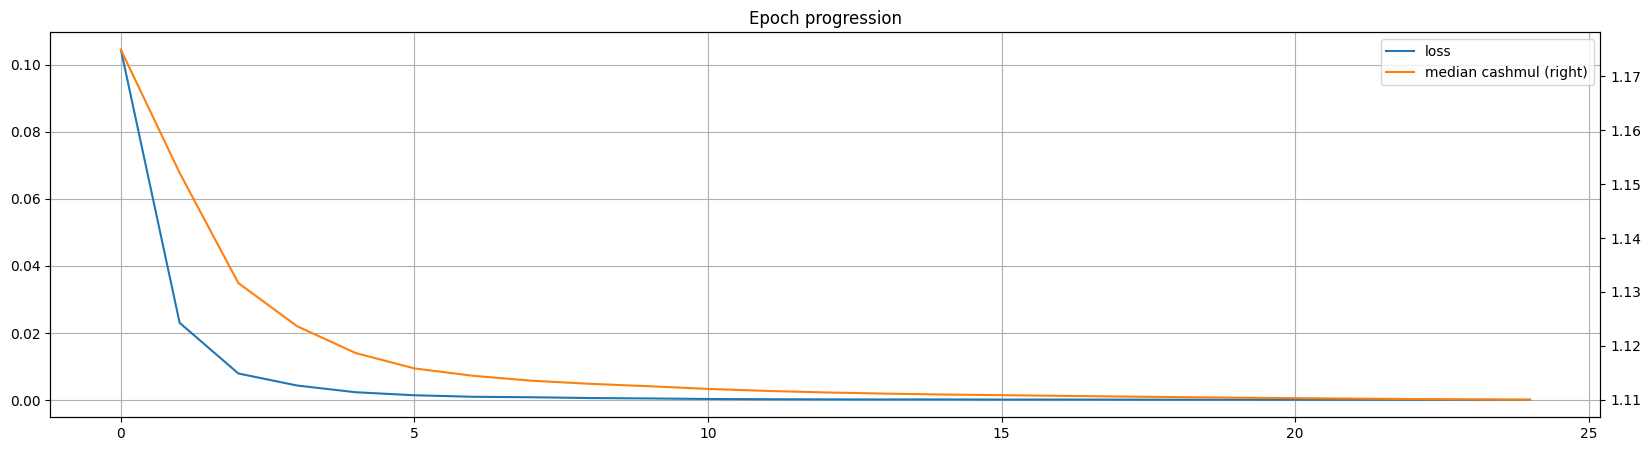

Assets  Liabilities  NetCashOperating_ttm     price  \
cik        snapshot                                                            
0000001750 2012-01-01  1.821612     0.957664              0.083588 19.170000   
           2012-02-01  1.821612     0.957664              0.083588 21.190000   
           2012-03-01  1.821612     0.957664              0.083588 22.050000   
           2012-04-01  2.220293     1.330213              0.066898 18.250000   
           2012-05-01  2.220293     1.330213              0.066898 15.450000   
...                         ...          ...                   ...       ...   
0001915657 2025-06-01 16.542000     7.355000              0.704000 36.130000   
           2025-07-01 16.542000     7.355000              0.704000 41.080000   
           2025-08-01 16.843000     7.561000              1.067000 43.940000   
           2025-09-01 16.843000     7.561000              1.067000 50.880000   
           2025-10-01 16.843000     7.561000              1.067000 52.340000   

                         asmul   cashmul    model  
cik        snapshot                                
0000001750 2012-01-01 1.651304 -1.890047 1.892386  
           2012-02-01 1.772398 -1.582439 2.138685  
           2012-03-01 1.816525 -1.289456 2.243556  
           2012-04-01 1.434985 -1.131098 1.780206  
           2012-05-01 1.281863 -1.152544 1.438796  
...                        ...       ...      ...  
0001915657 2025-06-01 0.739539  1.475389 5.917123  
           2025-07-01 0.777987  1.723374 6.727722  
           2025-08-01 0.764440  1.763554 7.196173  
           2025-09-01 0.815185  2.027782 8.332814  
           2025-10-01 0.822348  2.138834 8.571937  

[435893 rows x 7 columns]

In [12]:
model_train(pricing_model)
model_output = pricing_model.get_df()
model_output = model_output[~model_output['is_nan']].drop(columns=['is_nan'])
model_output

Let's see for how many ciks the achieved correlation is perfect and for how many it is not.

In [13]:
model_corr = model_output.groupby(by='cik')[[ml_label,'model']].corr().reset_index()
model_corr = model_corr[model_corr[model_corr.columns[1]]==ml_label][['cik','model']].rename(columns={'model':'corrcoef'}).set_index('cik')
model_corr.sort_values(by='corrcoef').round(6).value_counts()

corrcoef
1.000000    3419
0.999999      18
0.999998       6
0.999995       2
Name: count, dtype: int64

The prices dataset can lag significantly behind the fundamentals dataset in terms of available snapshot dates. We interpolate the asset and cash multipliers for the missing recent dates and re-compute the model, so that the most recent snapshots are also included in the final results.

In [14]:
mul_columns = ['asmul','cashmul']

def per_cik_processing(a_group):
    cik, df = a_group
    df = df.sort_index()
    df.loc[:,mul_columns] = df[mul_columns].interpolate()
    return df

result = pd.merge(snapshots,model_output.groupby(by=['snapshot','cik'])[mul_columns].mean(),left_index=True,right_index=True,how='left')

if __name__ == '__main__':
    with mp.Pool(processes=max_jobs) as p:
        result = pd.concat(list(p.map(per_cik_processing,result.groupby(by='cik'))))

result['model'] = result['asmul']*result['Assets'] - result['Liabilities'] + result['cashmul']*result['NetCashOperating_ttm']
result

ticker    Assets  Liabilities  \
snapshot   cik        date                                       
2012-01-01 0000001750 2011-11-30    AIR  1.821612     0.957664   
2012-02-01 0000001750 2011-11-30    AIR  1.821612     0.957664   
2012-03-01 0000001750 2011-11-30    AIR  1.821612     0.957664   
2012-04-01 0000001750 2012-02-29    AIR  2.220293     1.330213   
2012-05-01 0000001750 2012-02-29    AIR  2.220293     1.330213   
...                                 ...       ...          ...   
2025-07-01 0001915657 2025-03-31   DINO 16.542000     7.355000   
2025-08-01 0001915657 2025-06-30   DINO 16.843000     7.561000   
2025-09-01 0001915657 2025-06-30   DINO 16.843000     7.561000   
2025-10-01 0001915657 2025-06-30   DINO 16.843000     7.561000   
2025-10-11 0001915657 2025-06-30   DINO 16.843000     7.561000   

                                  NetCashOperating_ttm     price    asmul  \
snapshot   cik        date                                                  
2012-01-01 0000001750 2011-11-30              0.083588 19.170000 1.651304   
2012-02-01 0000001750 2011-11-30              0.083588 21.190000 1.772398   
2012-03-01 0000001750 2011-11-30              0.083588 22.050000 1.816525   
2012-04-01 0000001750 2012-02-29              0.066898 18.250000 1.434985   
2012-05-01 0000001750 2012-02-29              0.066898 15.450000 1.281863   
...                                                ...       ...      ...   
2025-07-01 0001915657 2025-03-31              0.704000 41.080000 0.777987   
2025-08-01 0001915657 2025-06-30              1.067000 43.940000 0.764440   
2025-09-01 0001915657 2025-06-30              1.067000 50.880000 0.815185   
2025-10-01 0001915657 2025-06-30              1.067000 52.340000 0.822348   
2025-10-11 0001915657 2025-06-30              1.067000       NaN 0.822348   

                                   cashmul    model  
snapshot   cik        date                           
2012-01-01 0000001750 2011-11-30 -1.890047 1.892386  
2012-02-01 0000001750 2011-11-30 -1.582439 2.138685  
2012-03-01 0000001750 2011-11-30 -1.289456 2.243556  
2012-04-01 0000001750 2012-02-29 -1.131098 1.780206  
2012-05-01 0000001750 2012-02-29 -1.152544 1.438796  
...                                    ...      ...  
2025-07-01 0001915657 2025-03-31  1.723374 6.727722  
2025-08-01 0001915657 2025-06-30  1.763554 7.196174  
2025-09-01 0001915657 2025-06-30  2.027782 8.332813  
2025-10-01 0001915657 2025-06-30  2.138834 8.571937  
2025-10-11 0001915657 2025-06-30  2.138834 8.571937  

[454409 rows x 8 columns]

It is interesting to see the development of the two multipliers over time. The cash multiplier is the same for all ciks on a given snapshot date and can probably serve as some form of valuation metric for the whole market.

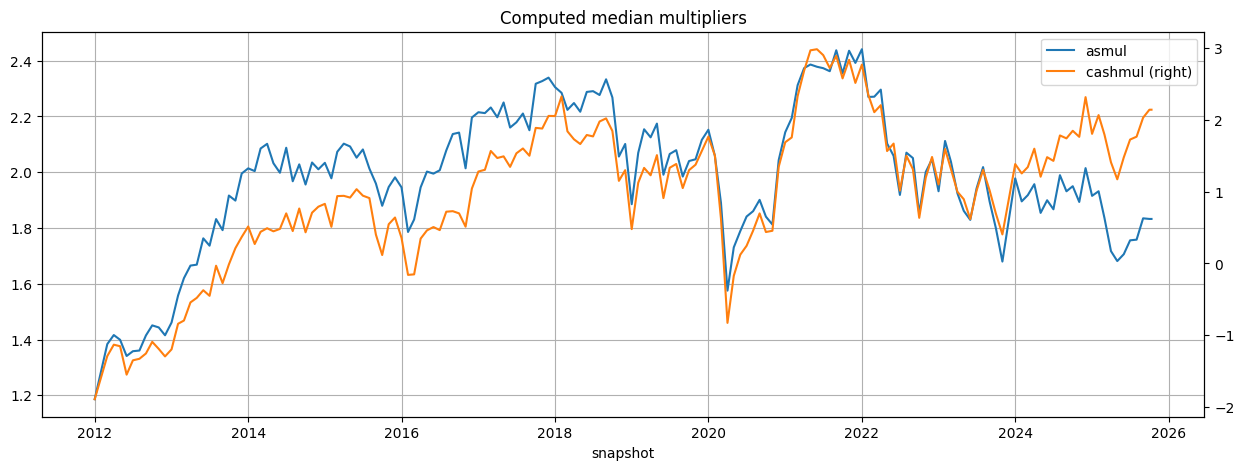

Median log10(asmul) per cik: 0.3715890049934387
Median log10(asmul) per snapshot: 0.30154889822006226


In [15]:
mul_graph = result.groupby(by='snapshot')[mul_columns].median()
mul_graph['asmul'].plot(title='Computed median multipliers',figsize=(15,5),grid=True,legend=True)
mul_graph['cashmul'].plot(secondary_y=True,legend=True,grid=False)
plt.show()
print("Median log10(asmul) per cik:",np.log10(result['asmul']).groupby(by=['cik']).median().median())
print("Median log10(asmul) per snapshot:",np.log10(result['asmul']).groupby(by=['snapshot']).median().median())

In [16]:
# We can now output the results for later use in other models/notebooks/datasets
result.to_csv('/kaggle/working/pricing_model.csv.gz')

Finally, we apply the model to individual ciks. We have tried to make the selection of sample tickers as varied as possible in terms of company kinds and sizes. By following the development of the asset_multiplier of each company over time, we can make some estimates if and how much the stock price corresponds to the financial fundamentals.

In other words, we may be able to determine if a stock is relatively over-or-undervalued, compared to its historic fundamentals.

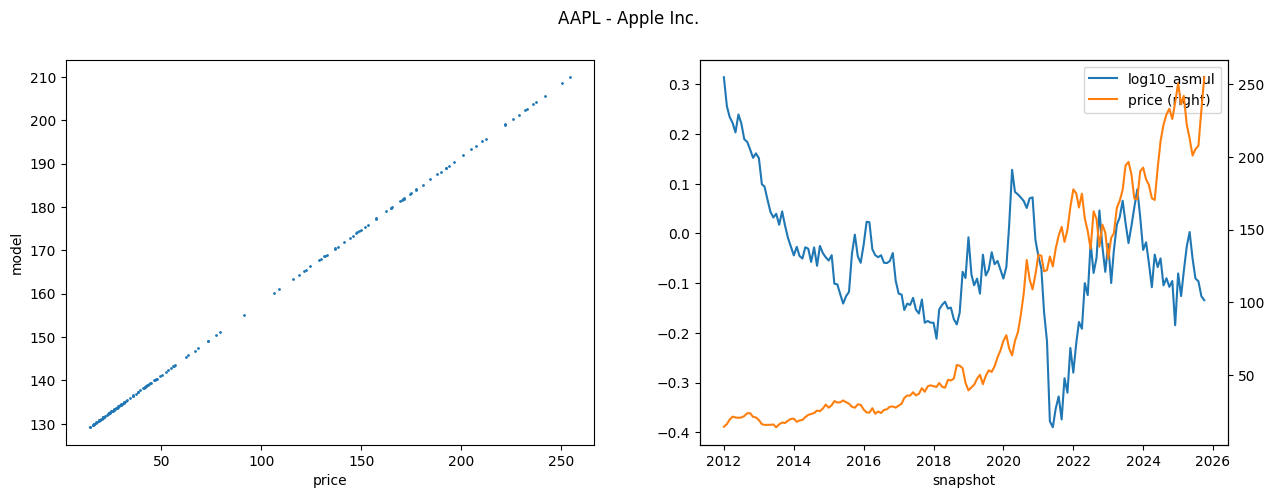

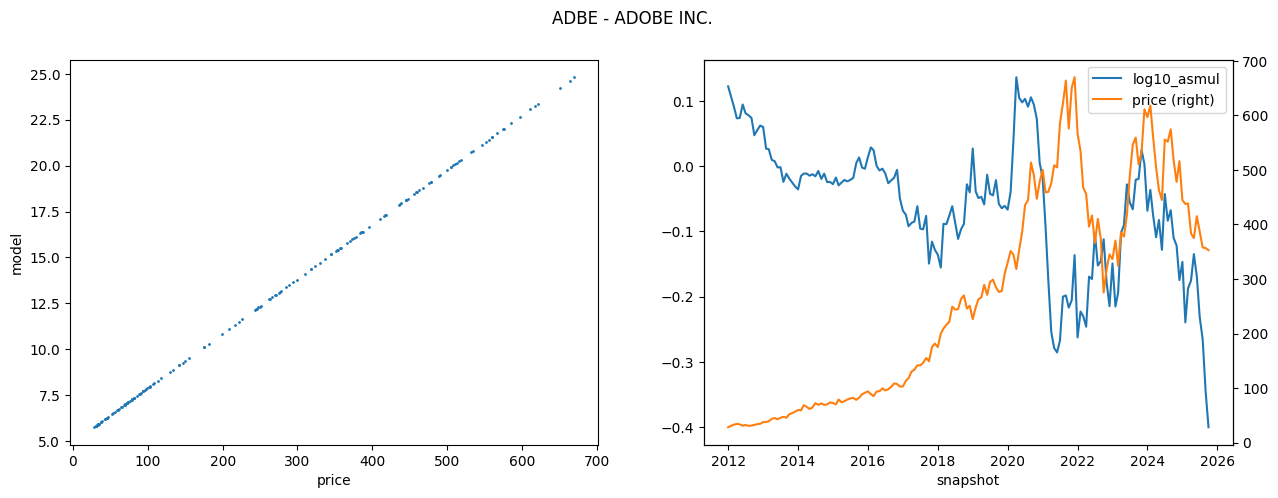

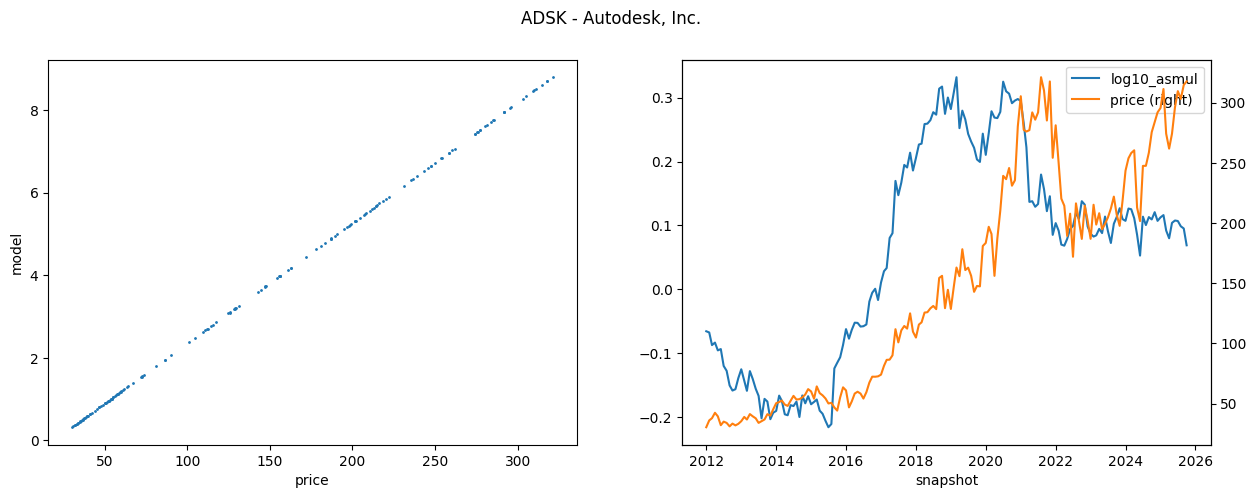

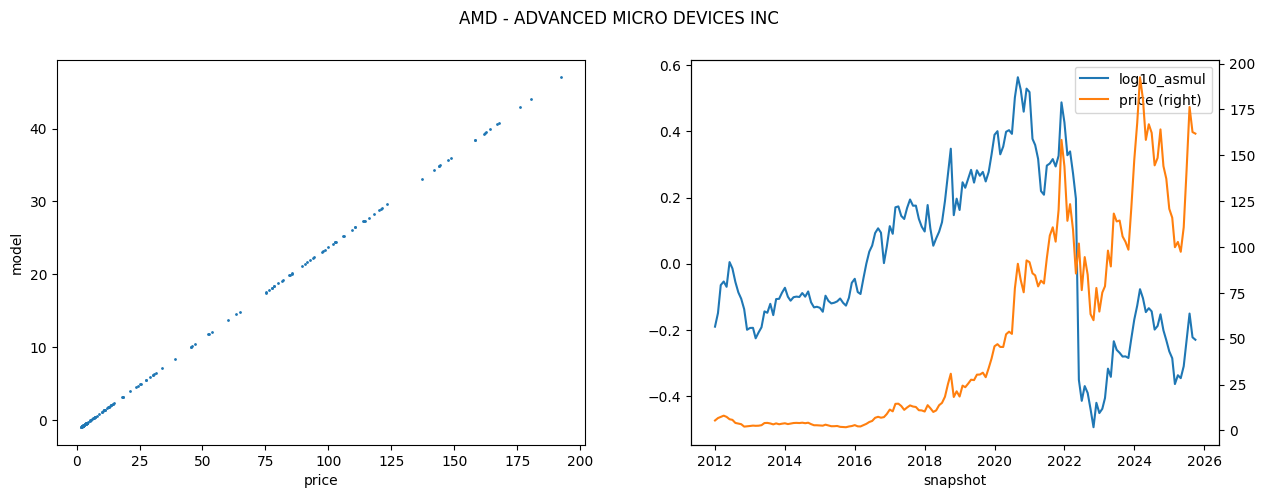

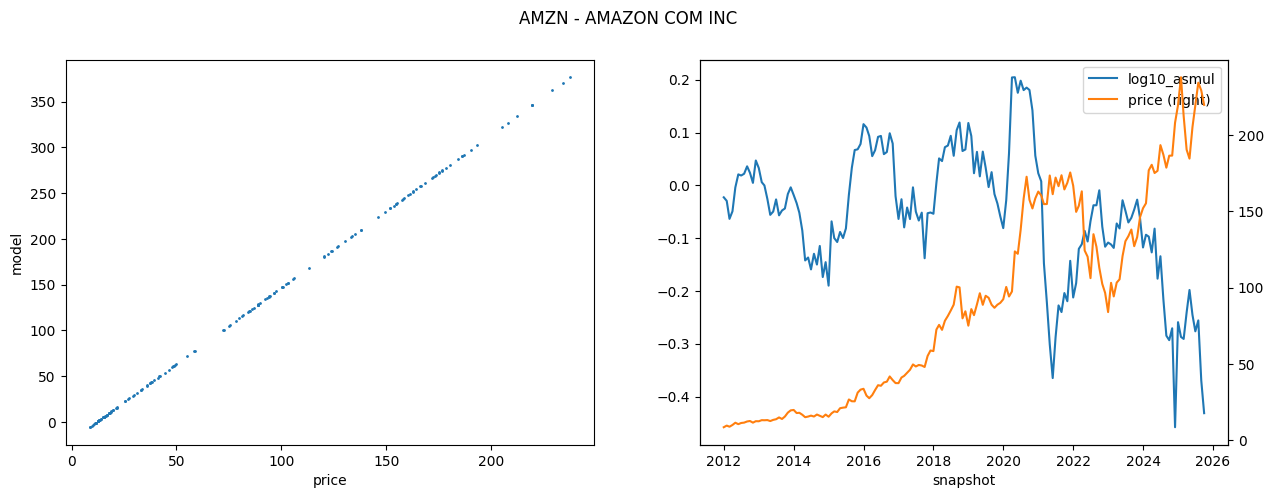

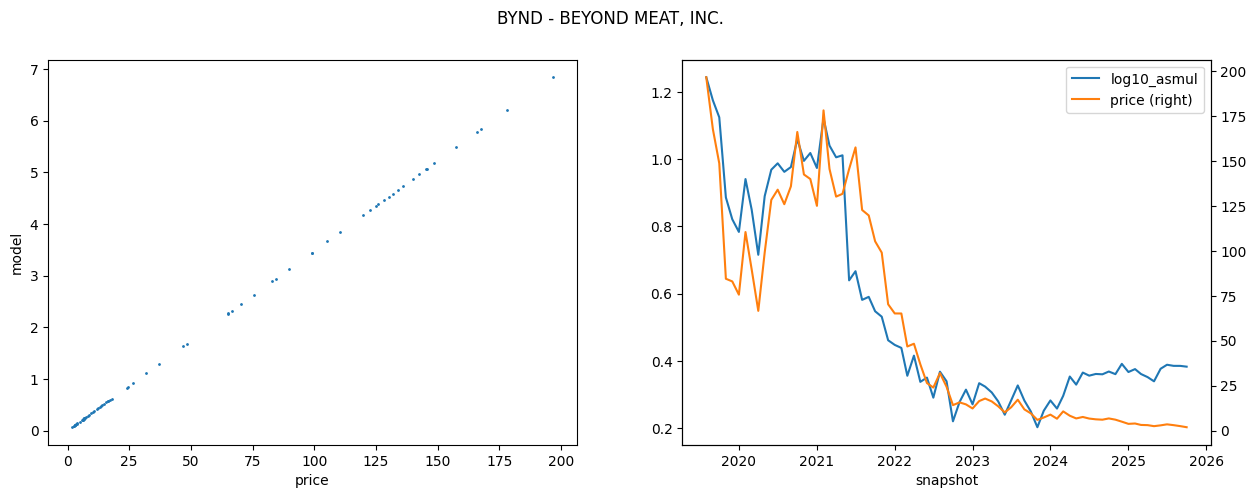

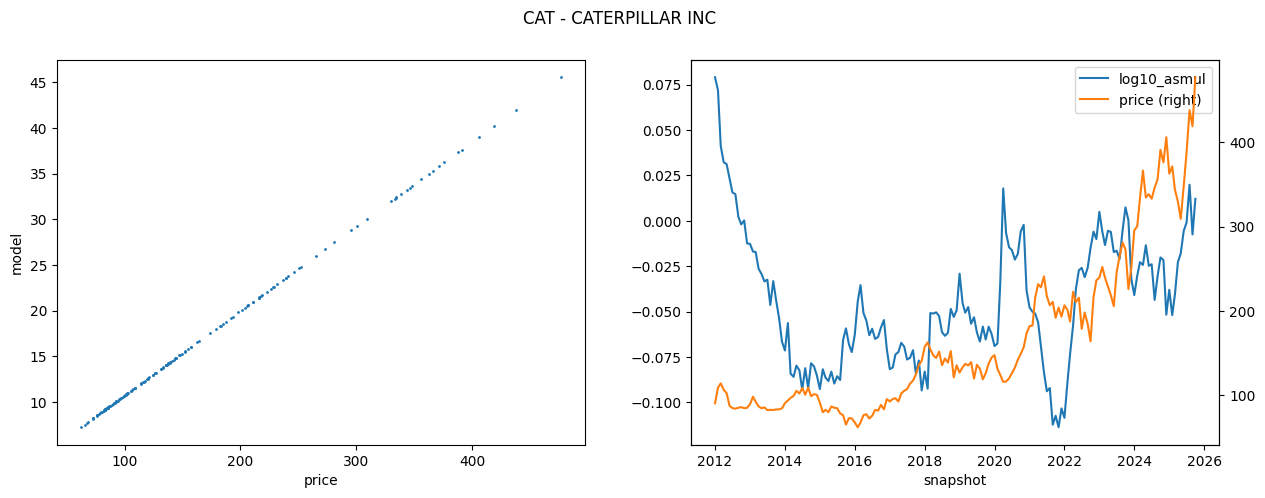

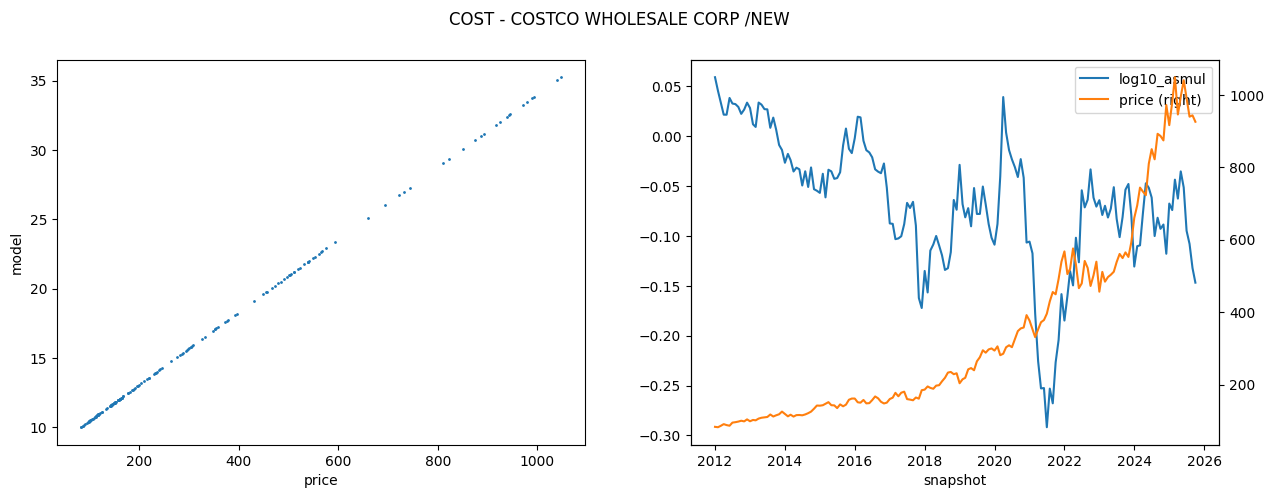

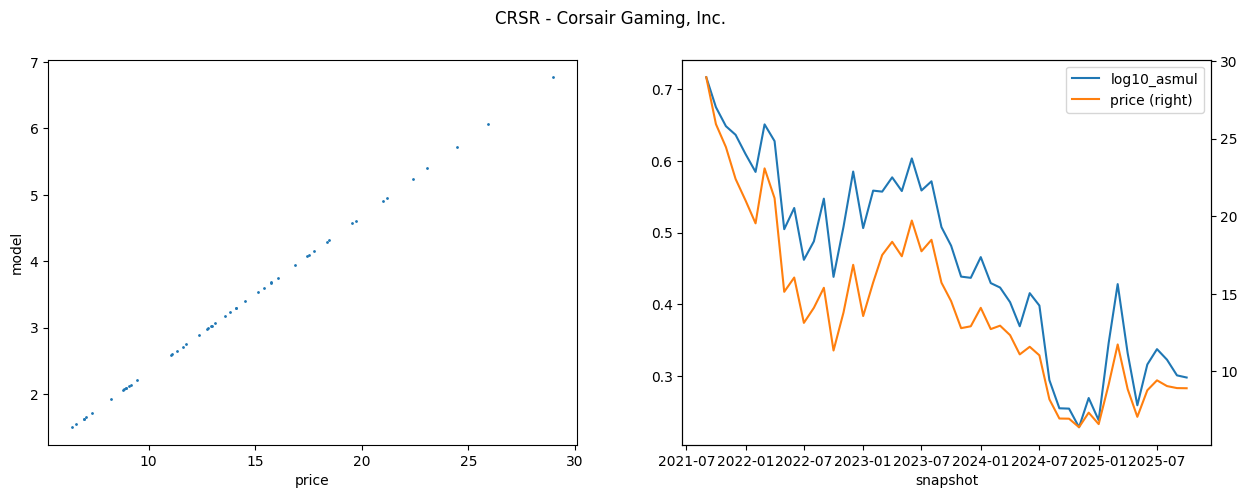

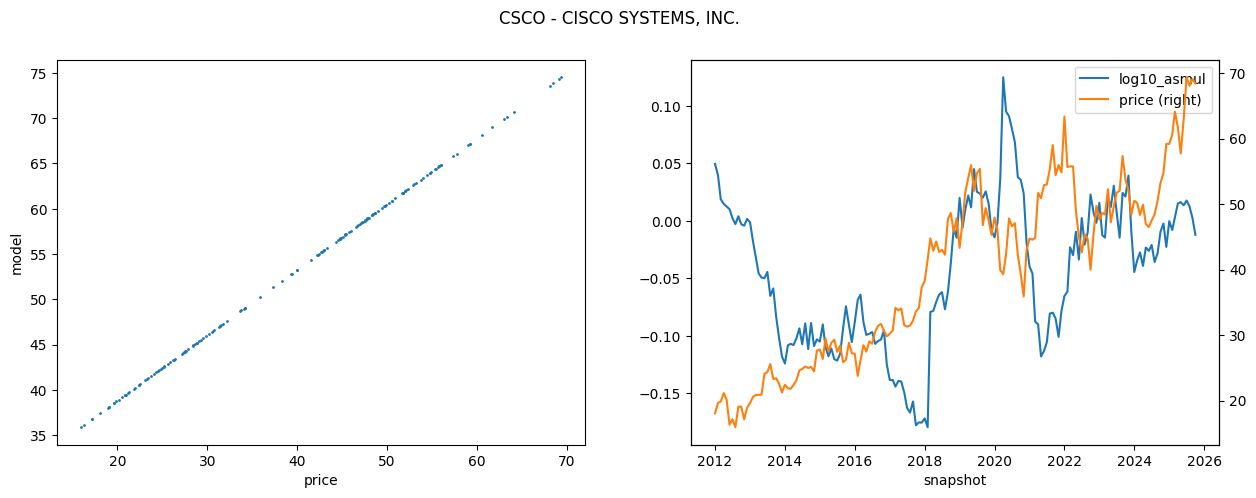

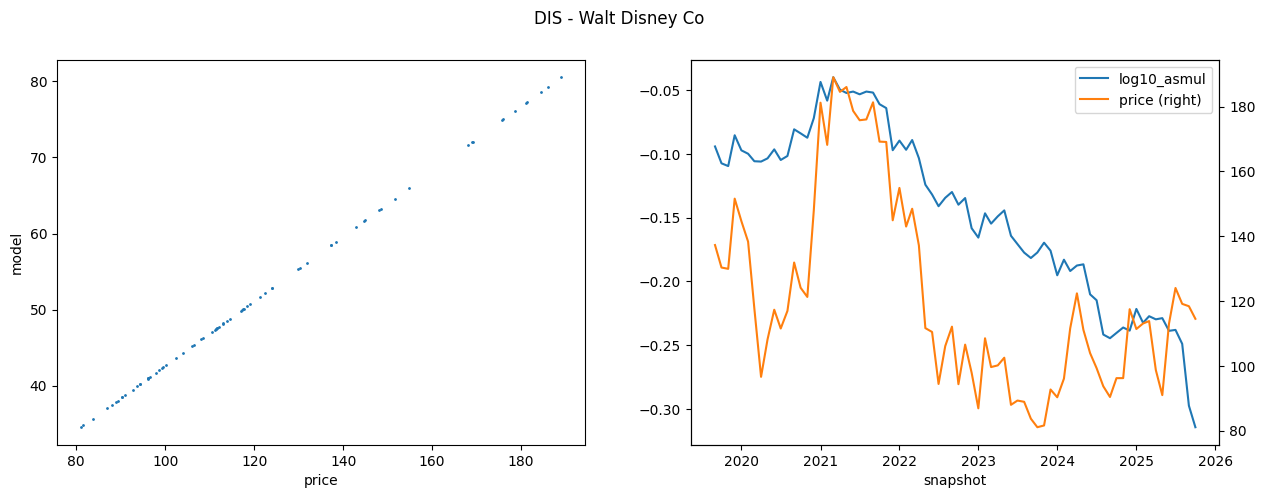

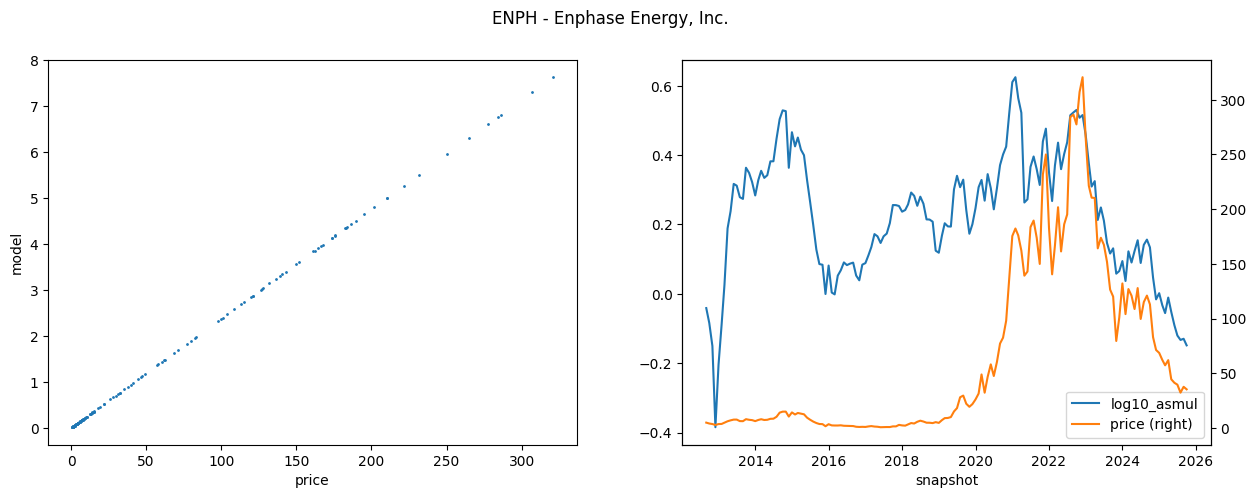

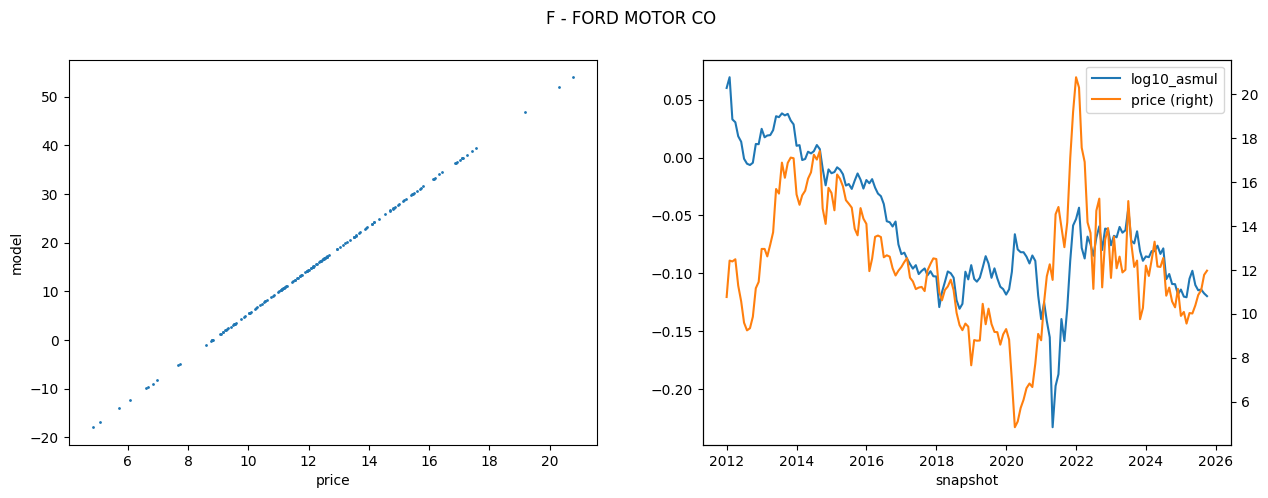

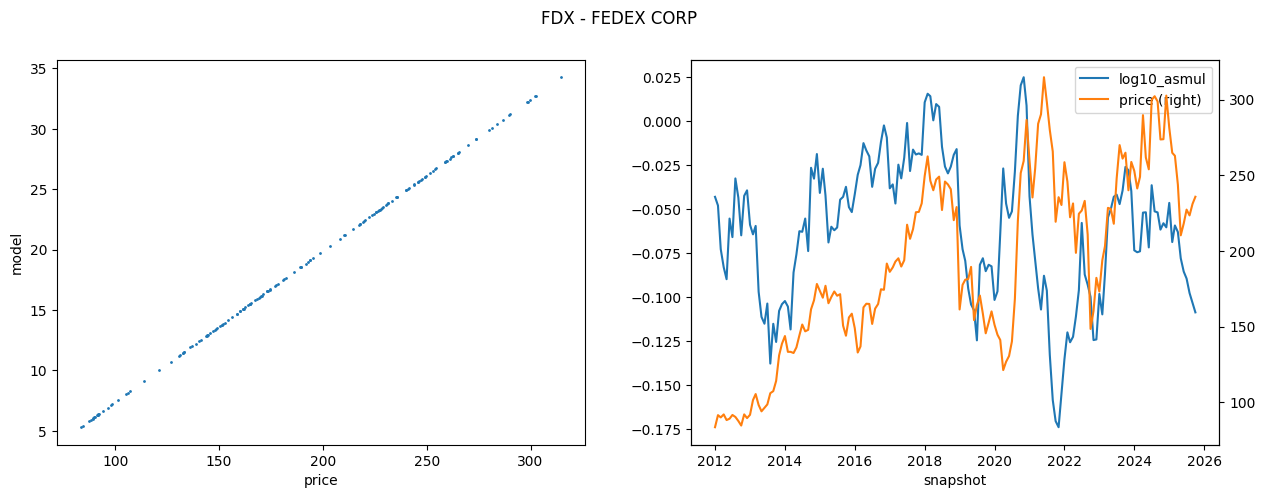

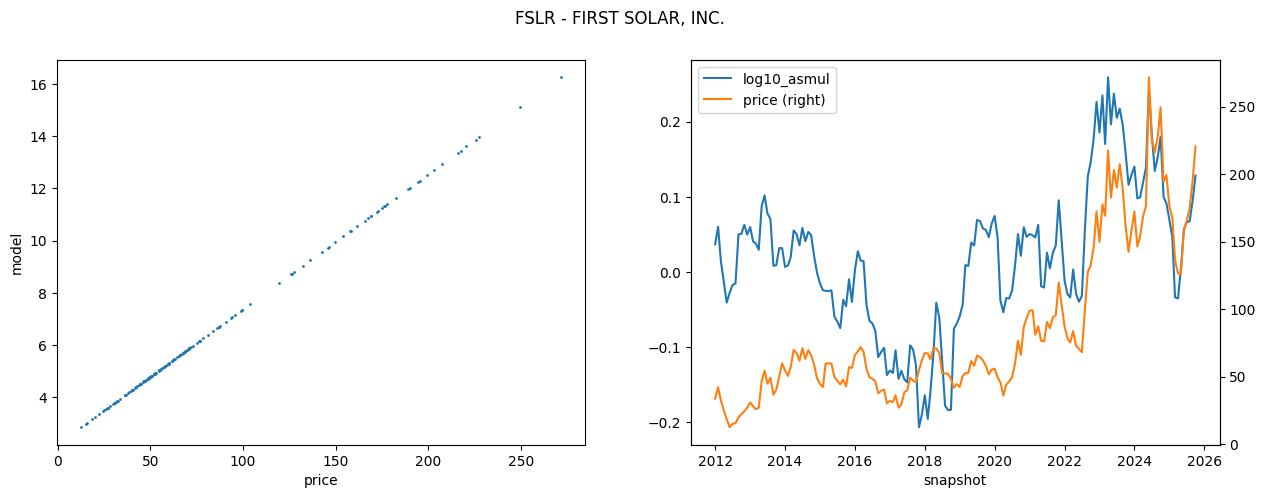

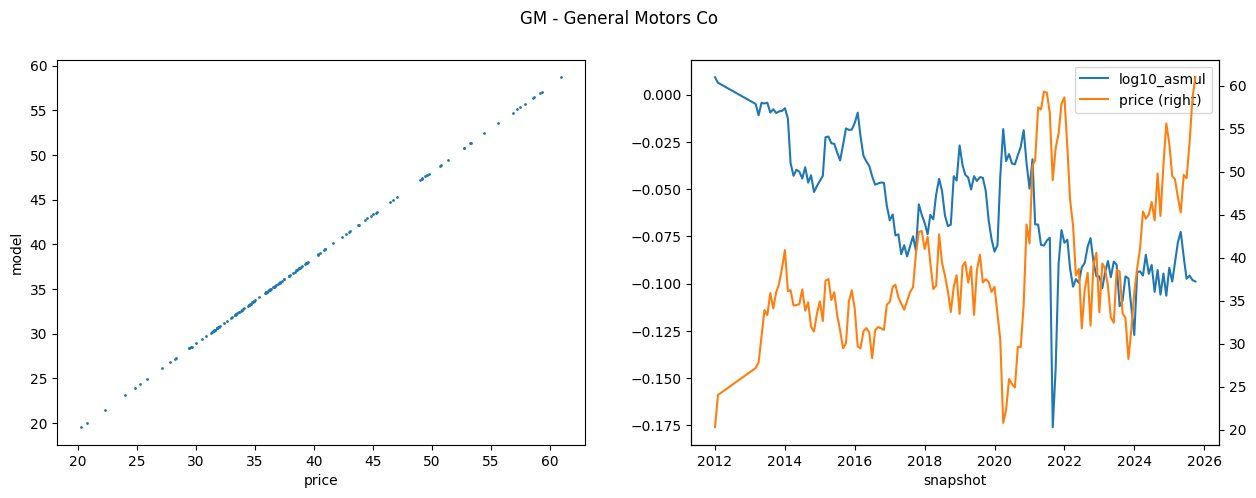

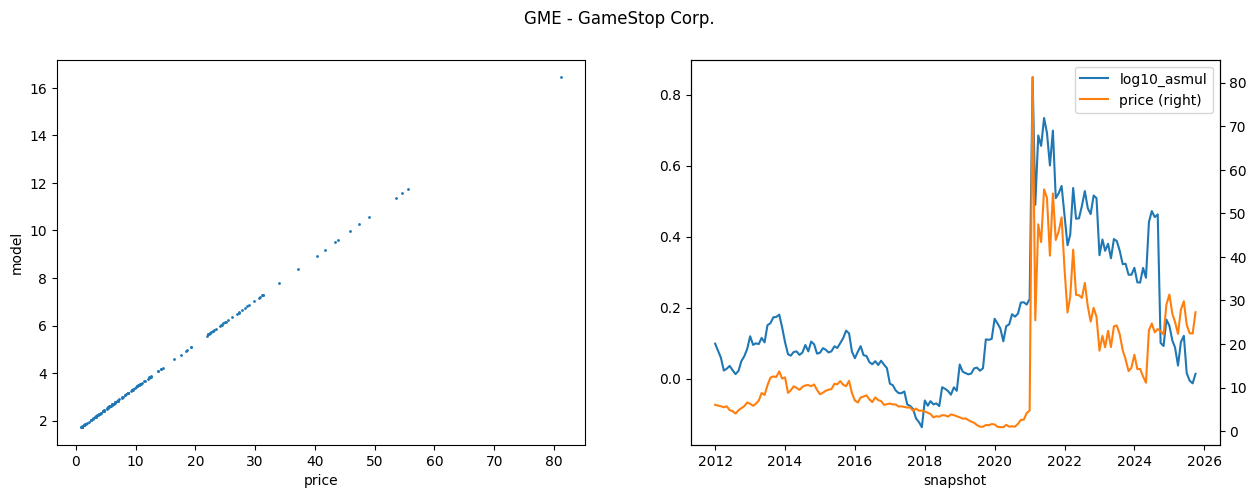

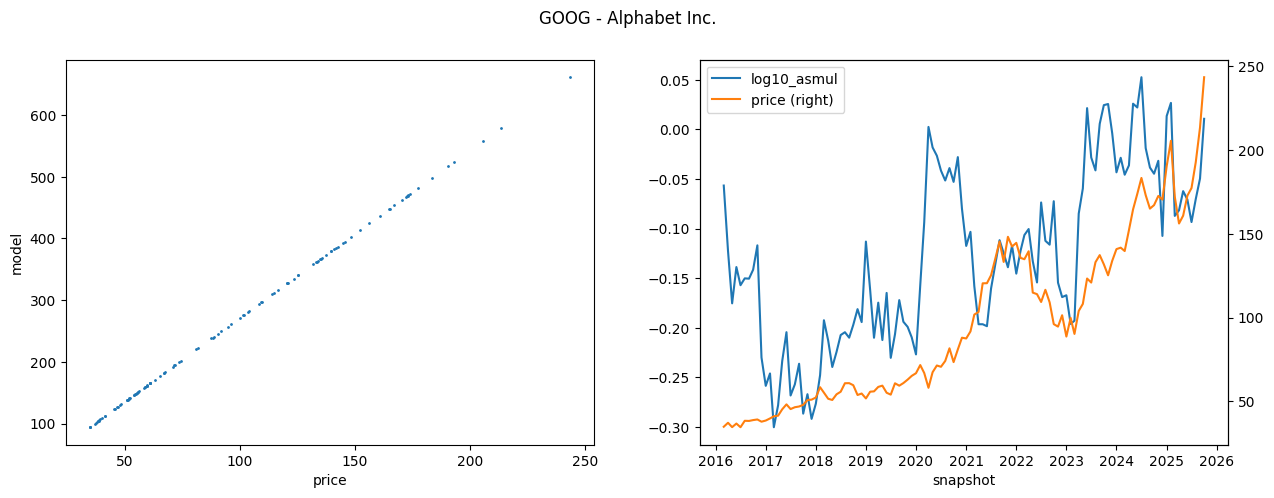

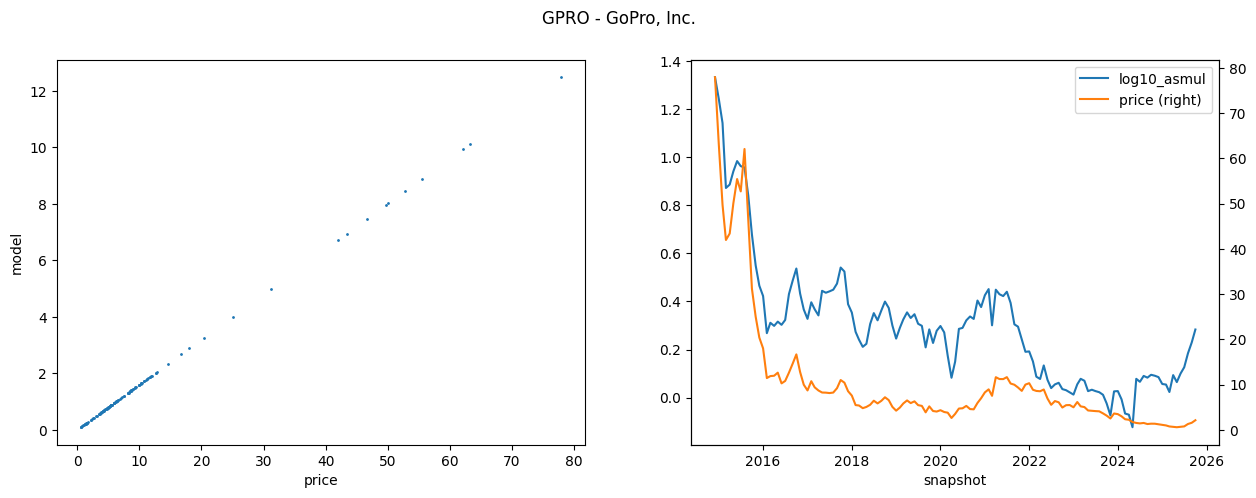

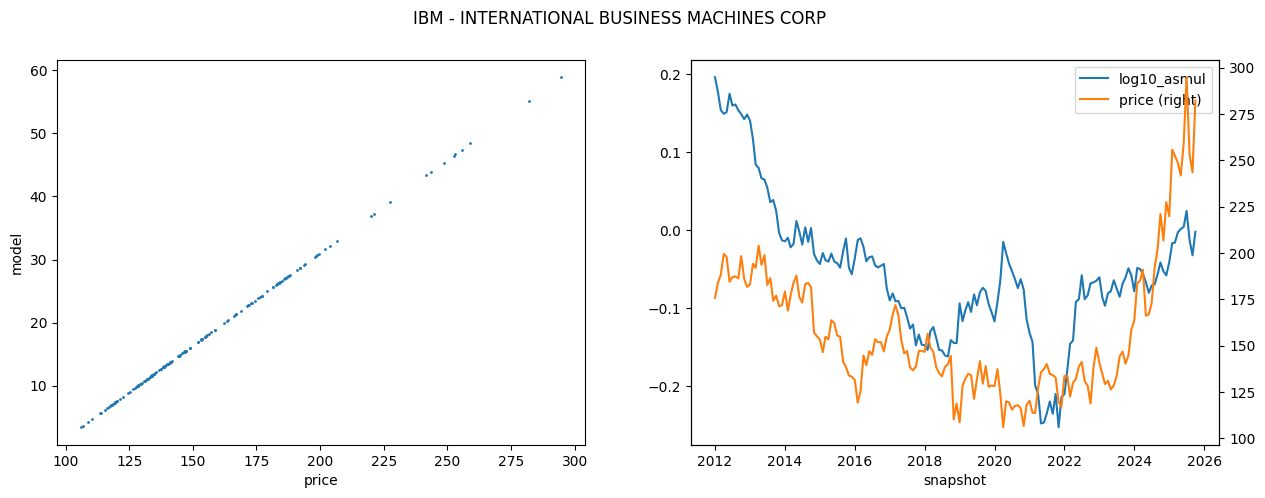

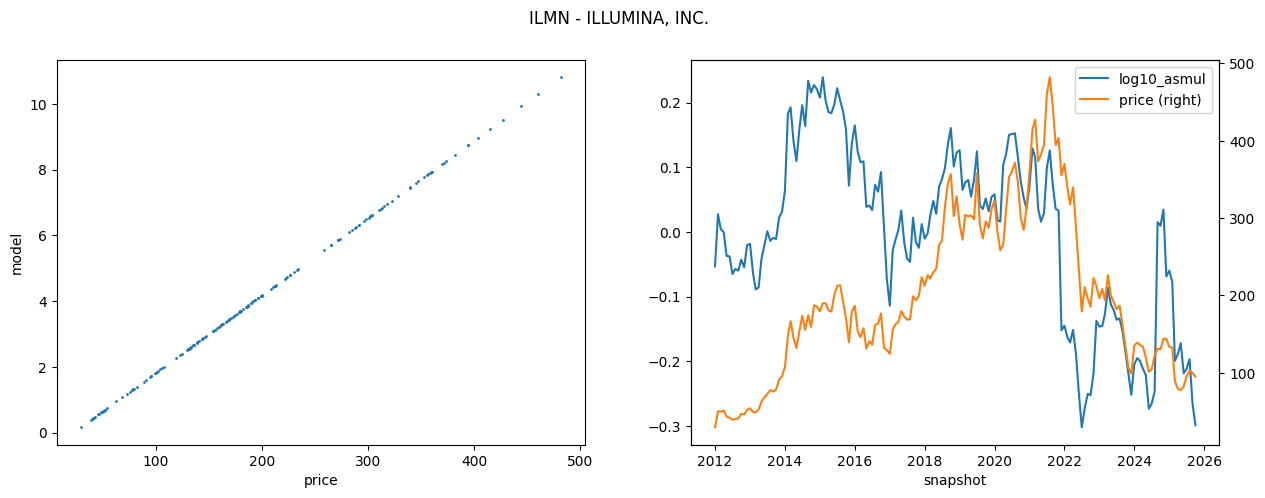

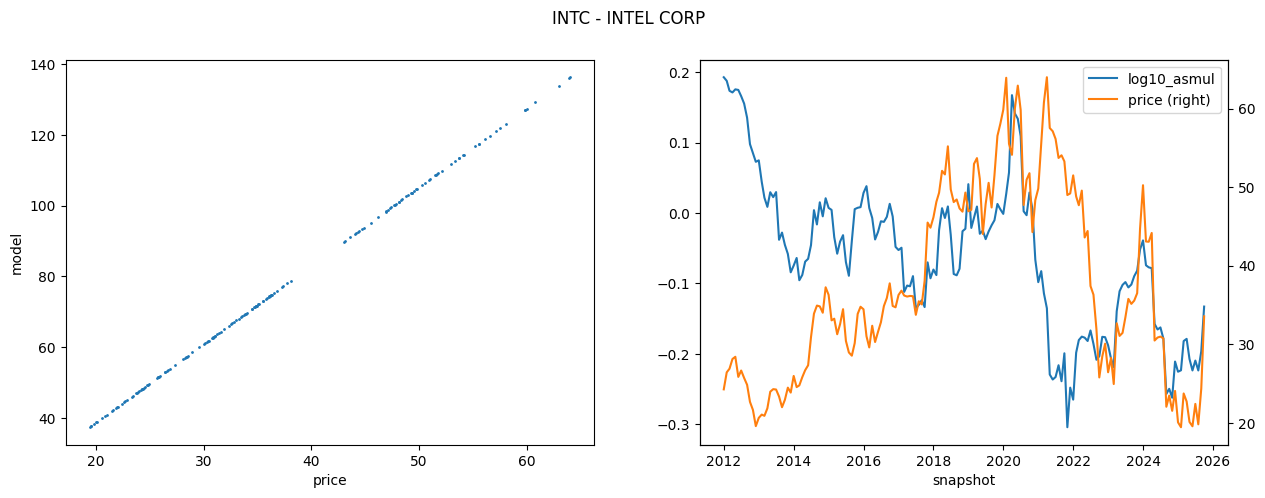

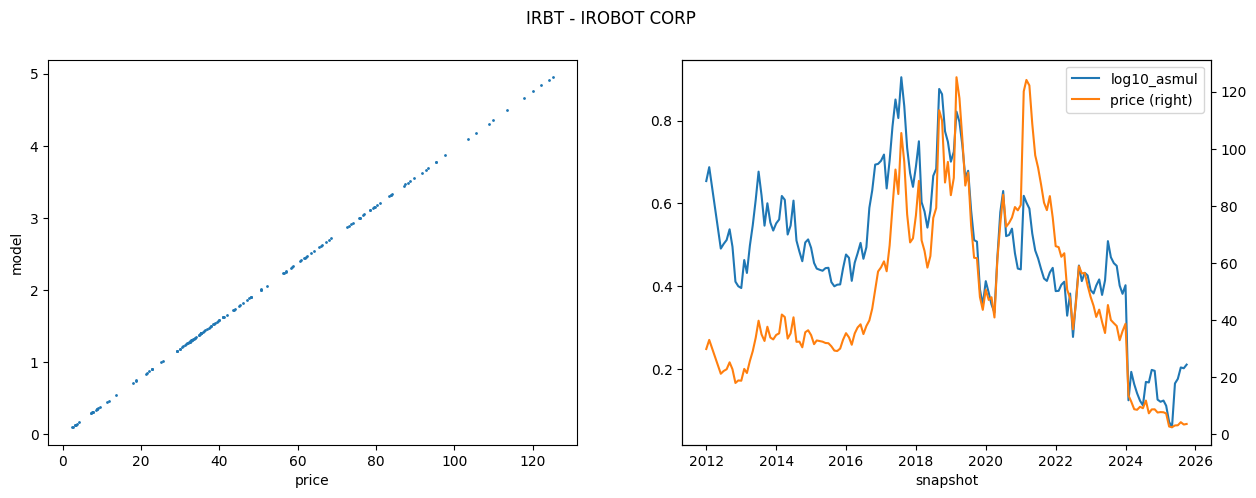

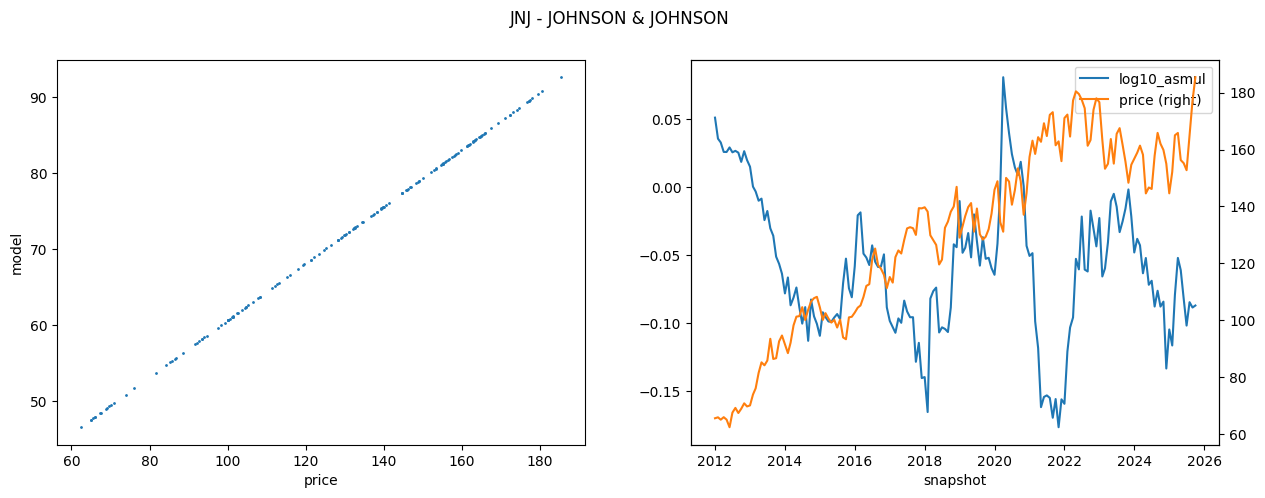

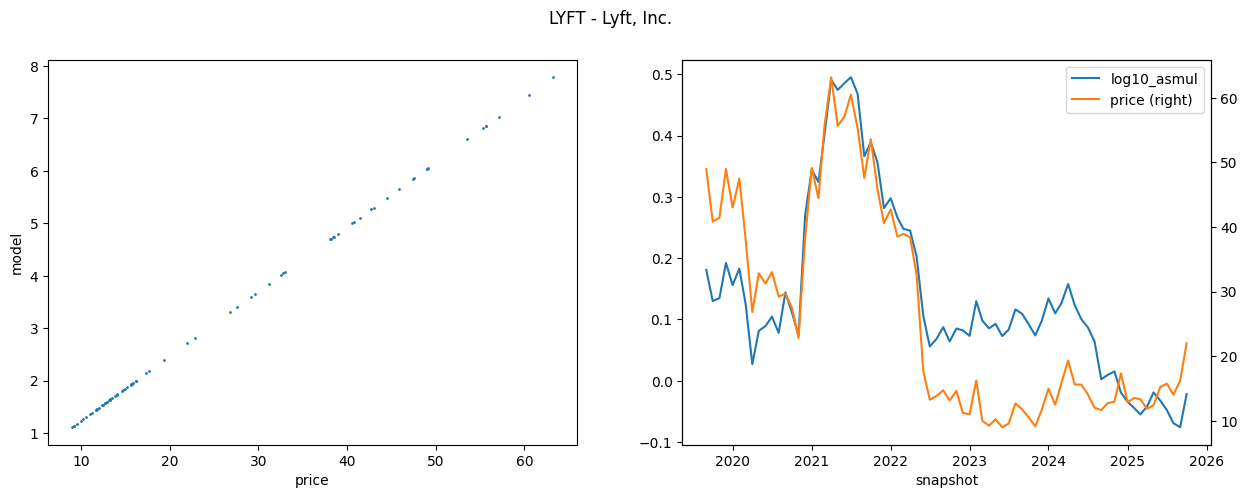

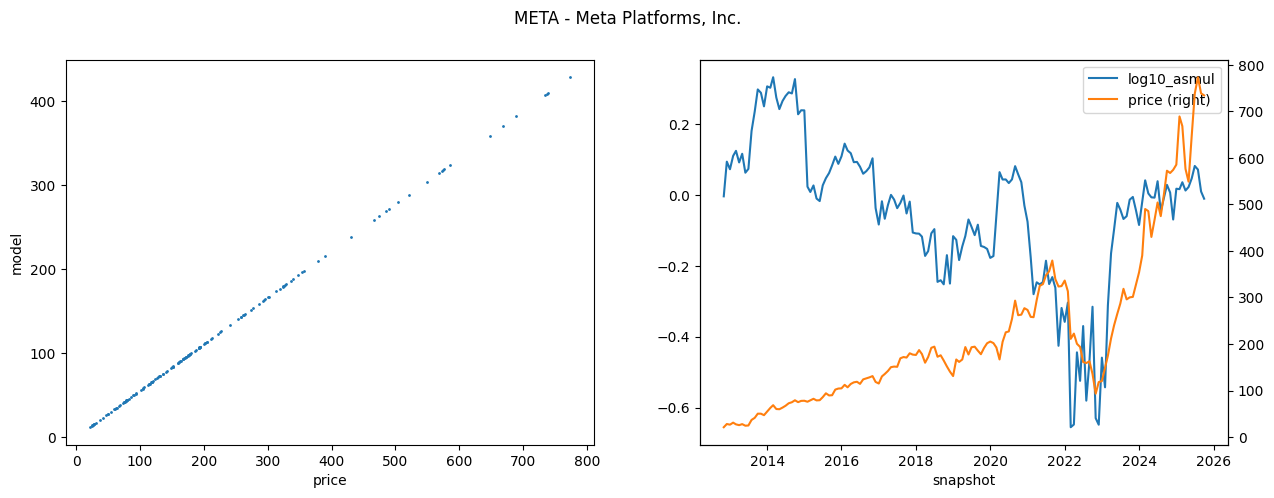

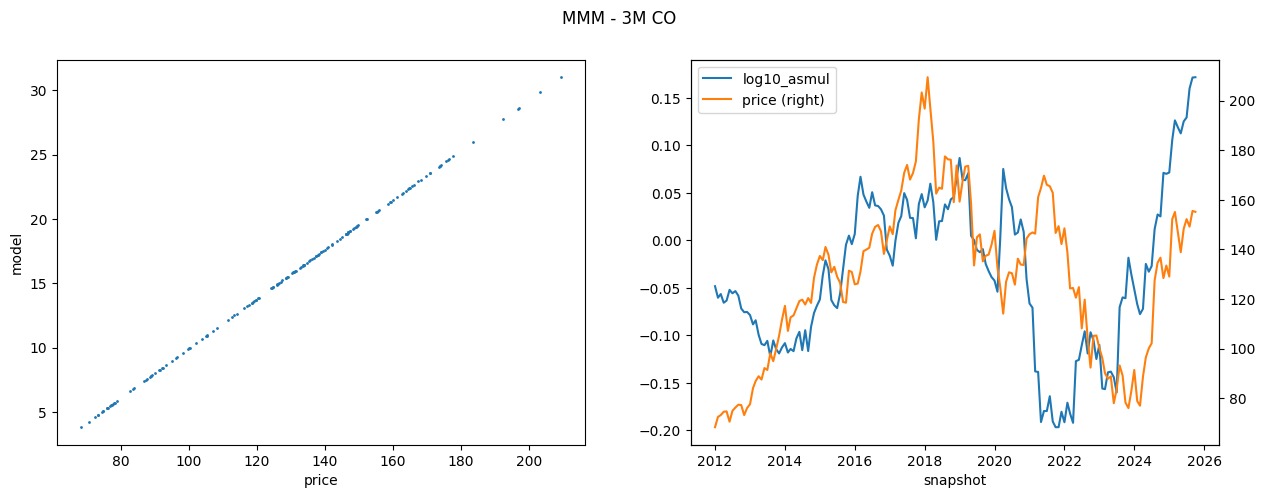

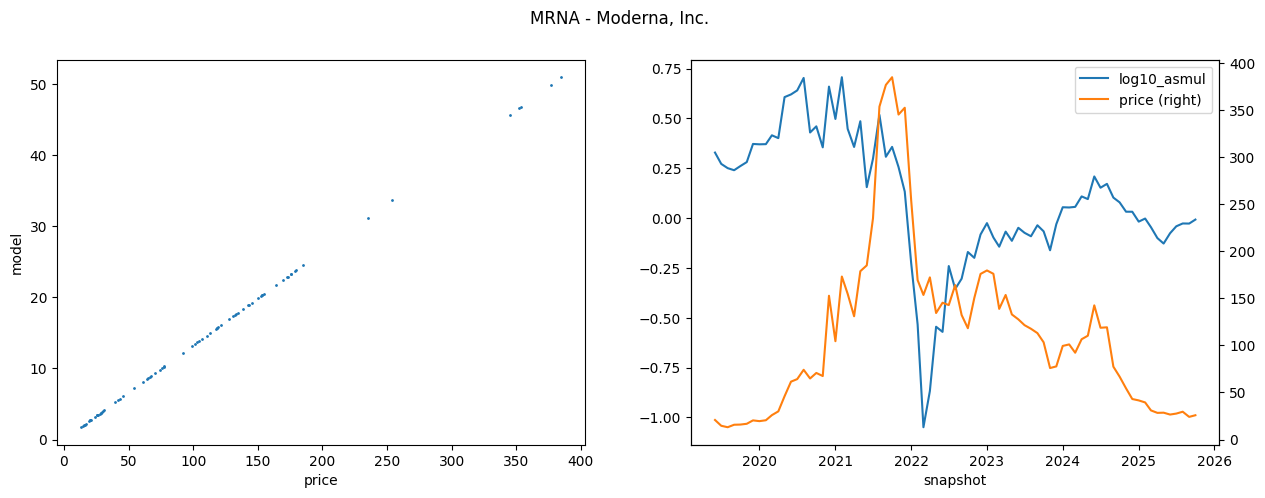

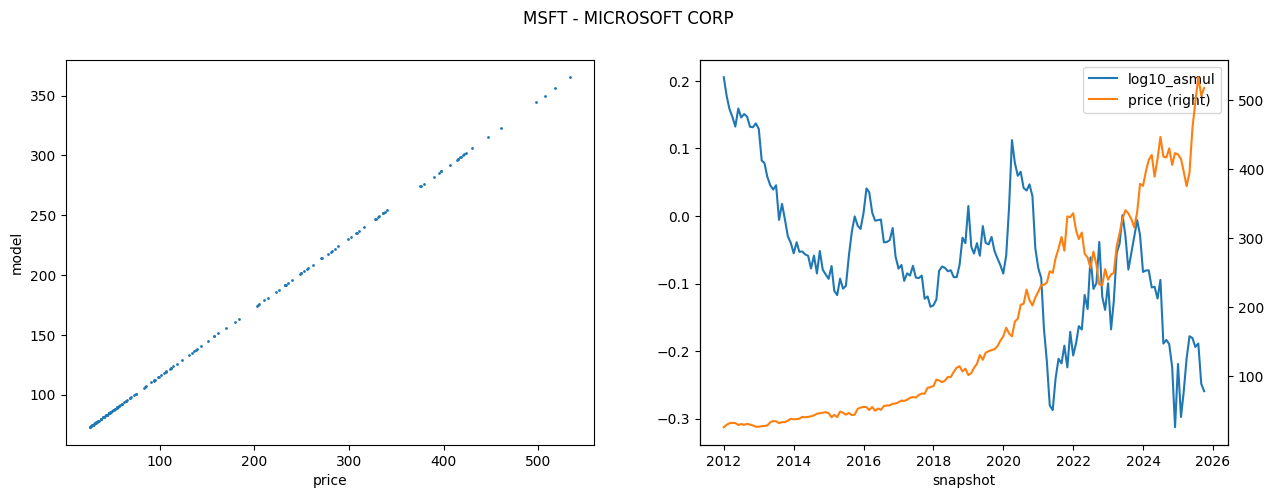

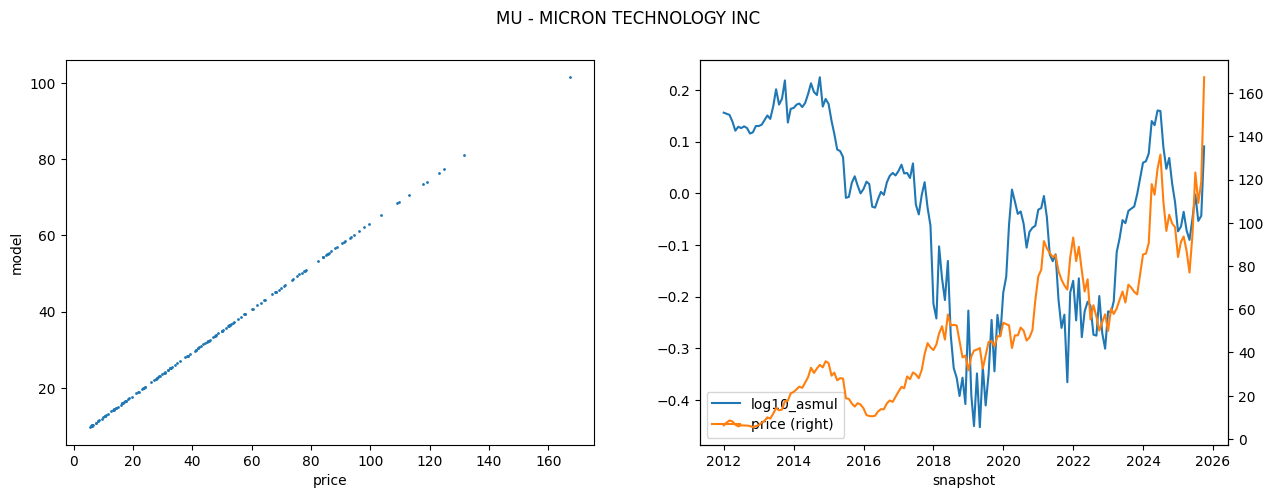

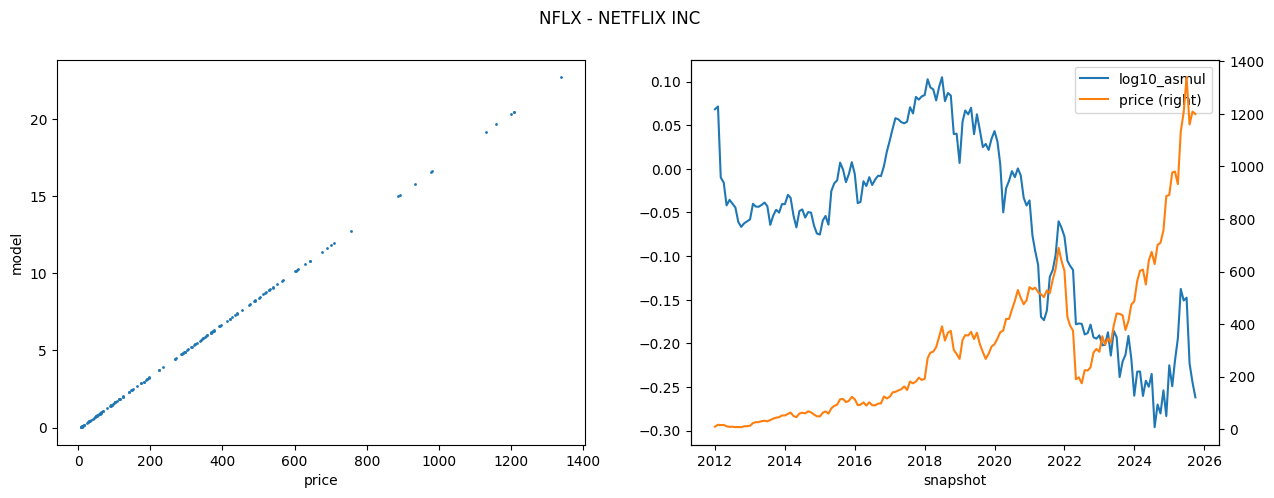

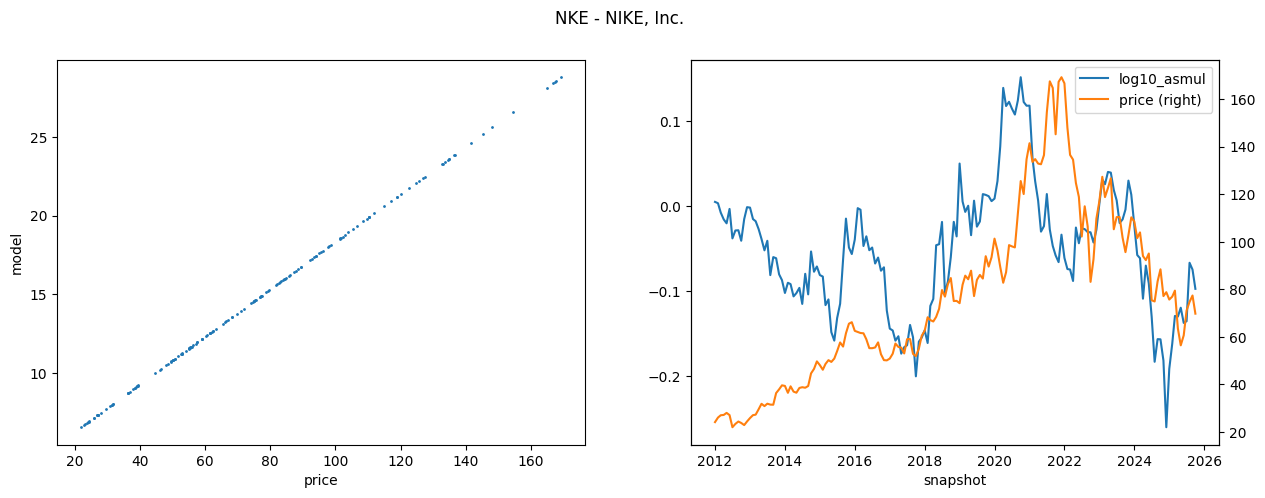

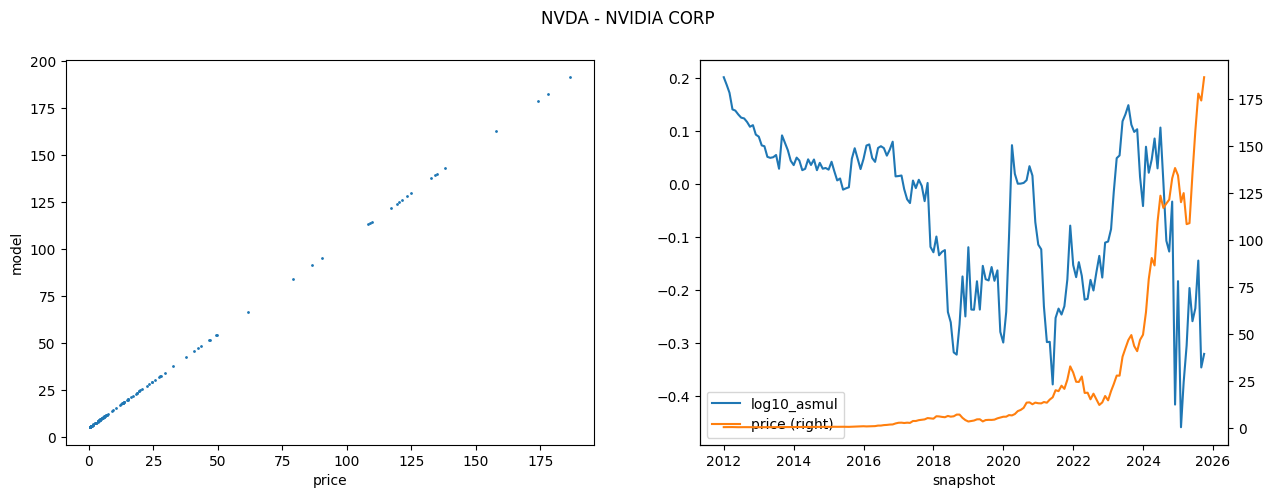

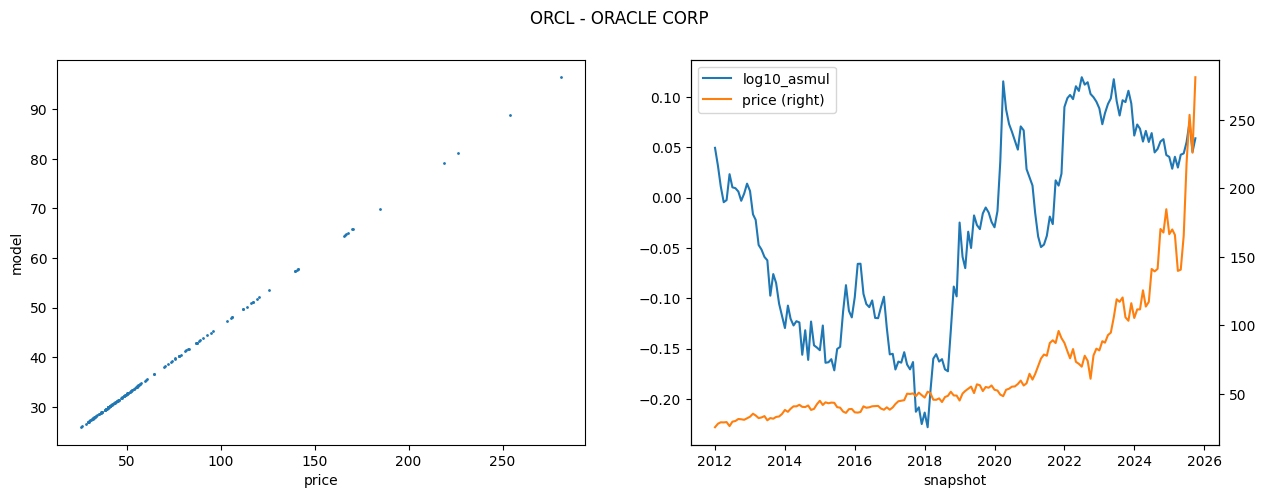

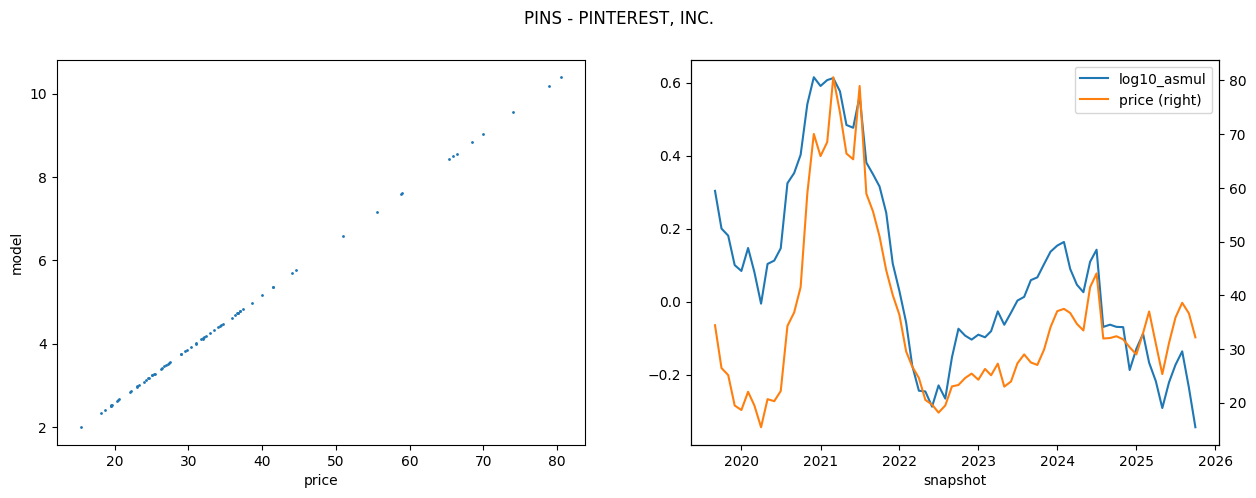

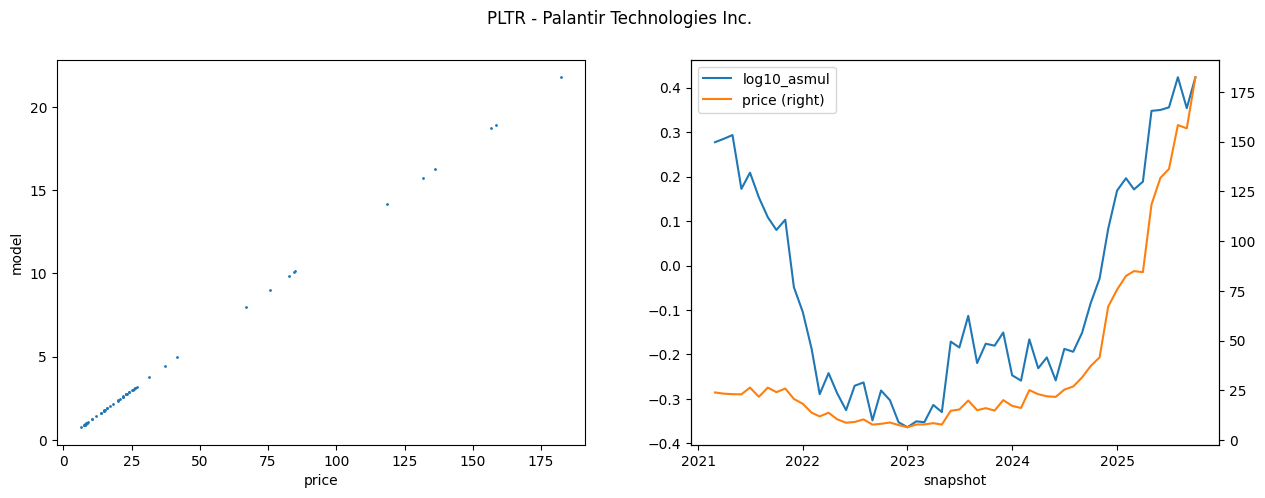

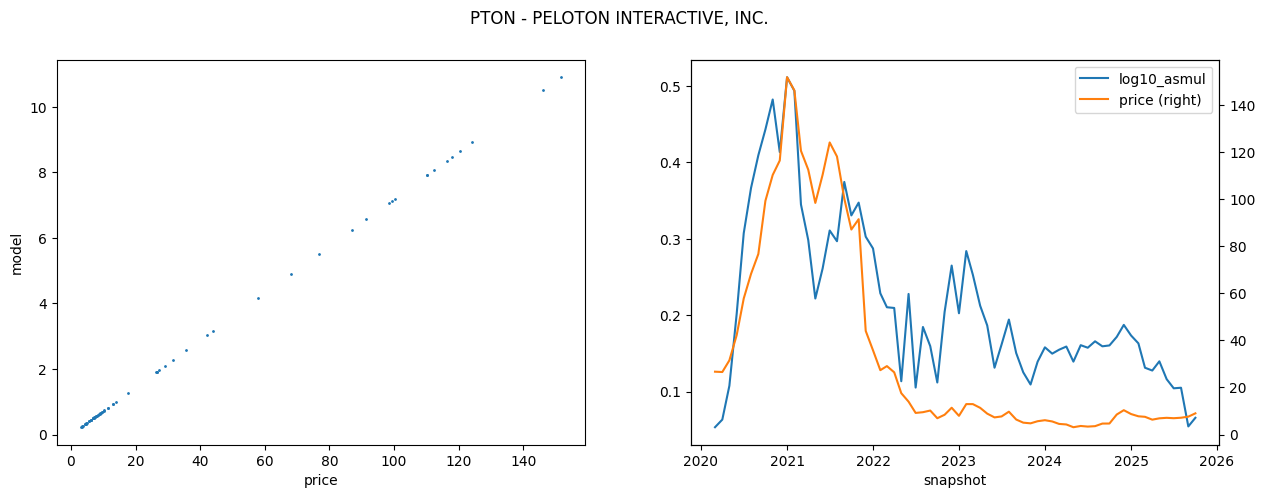

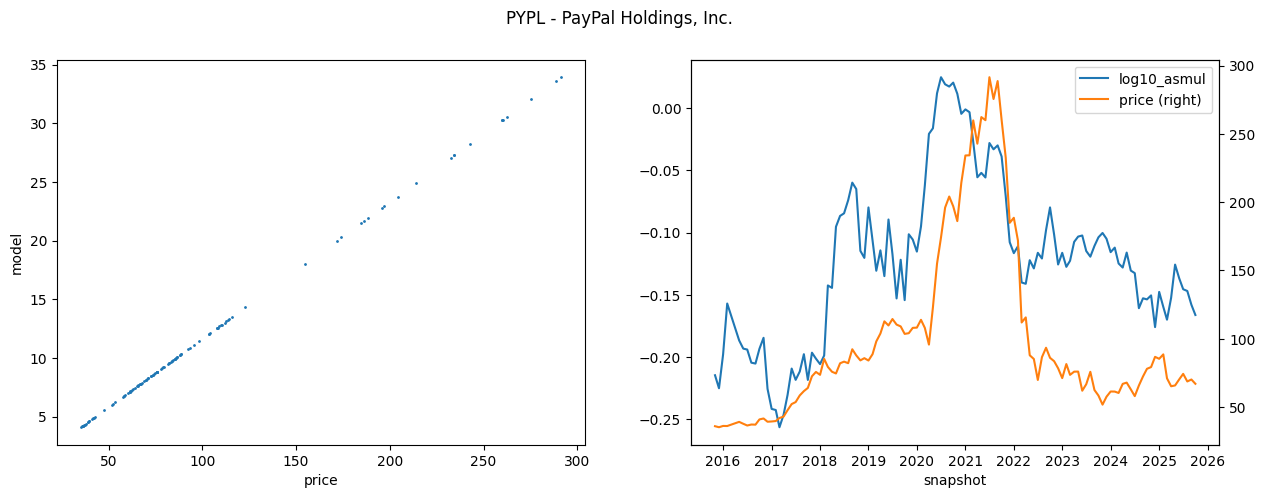

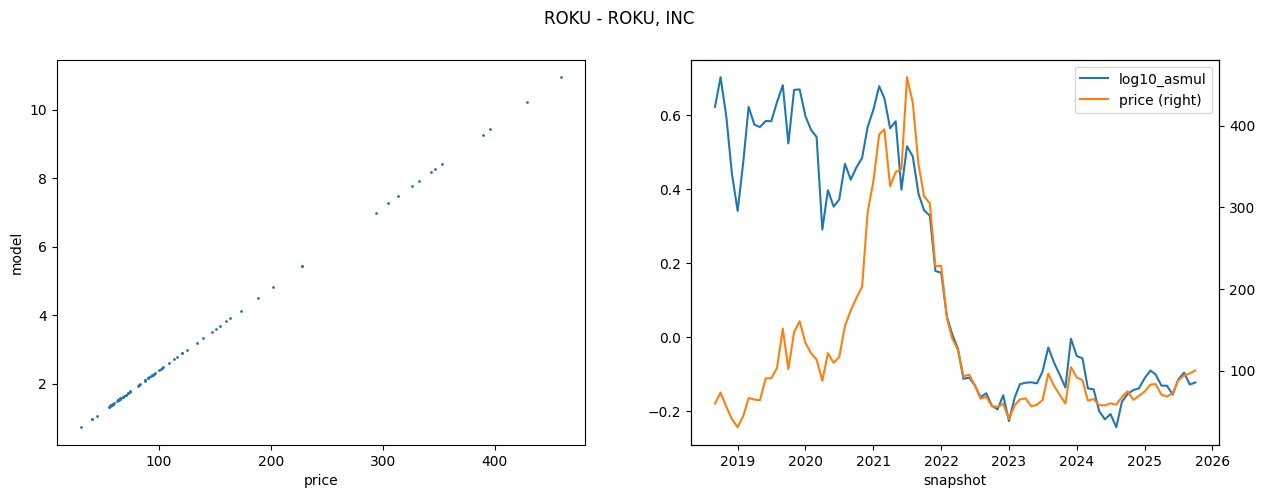

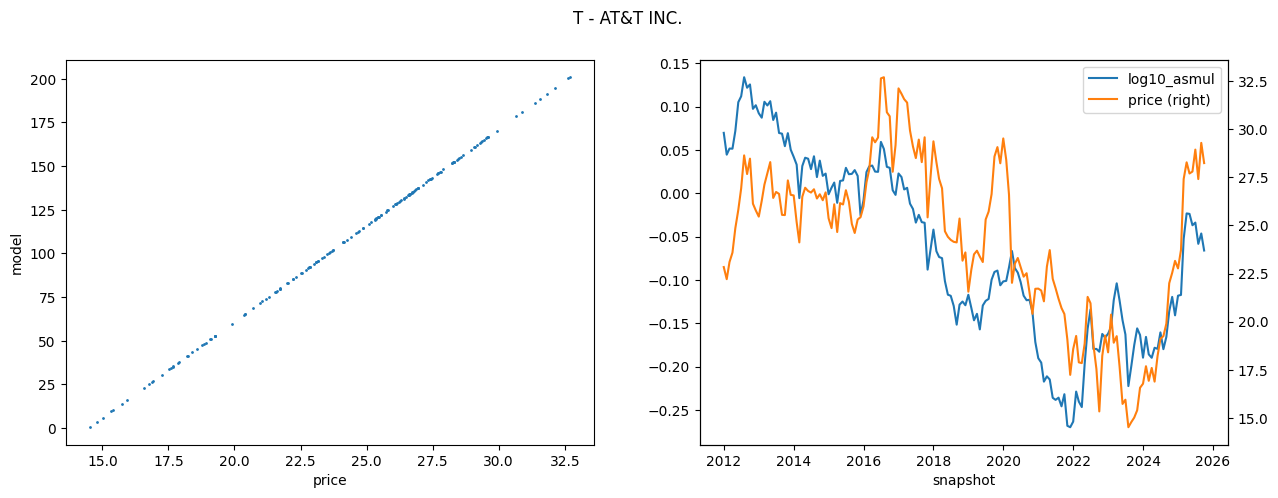

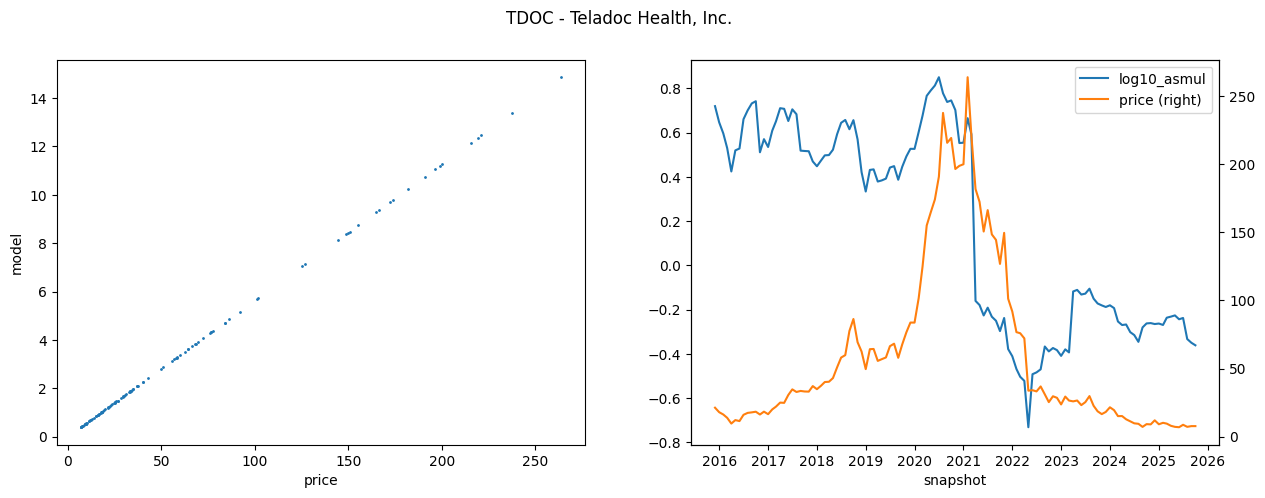

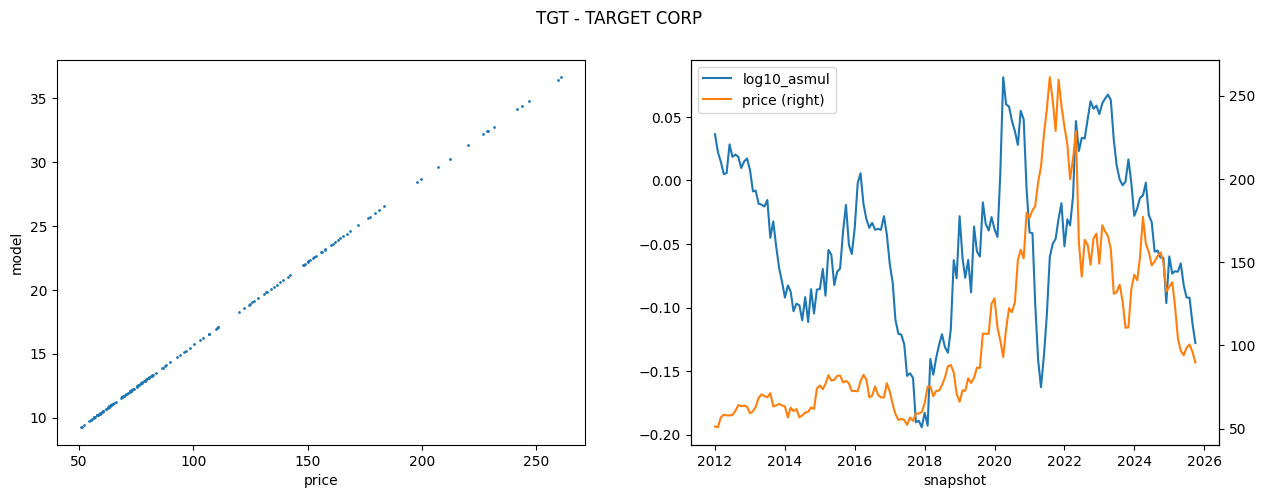

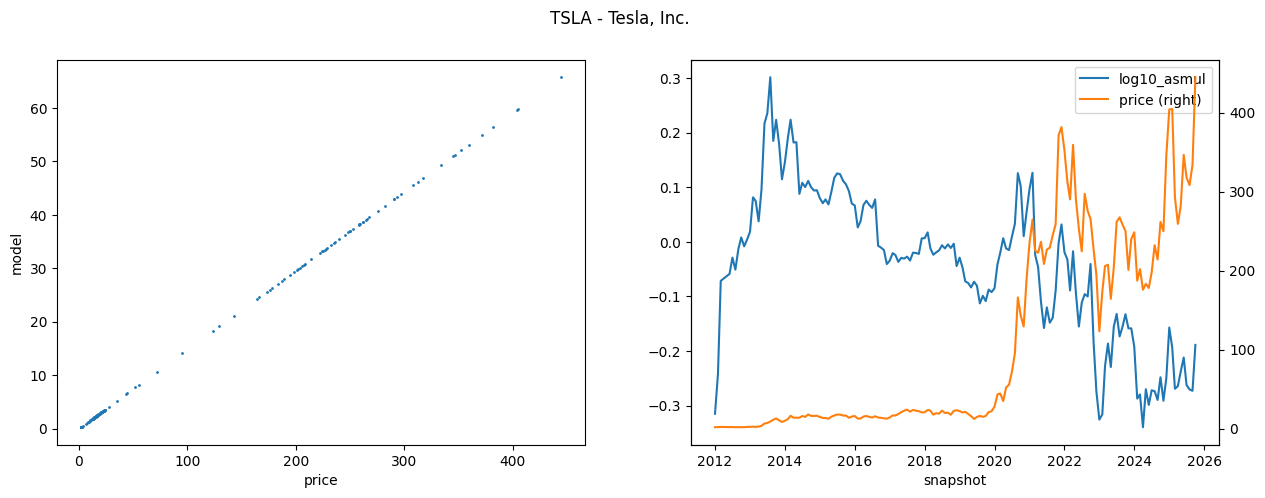

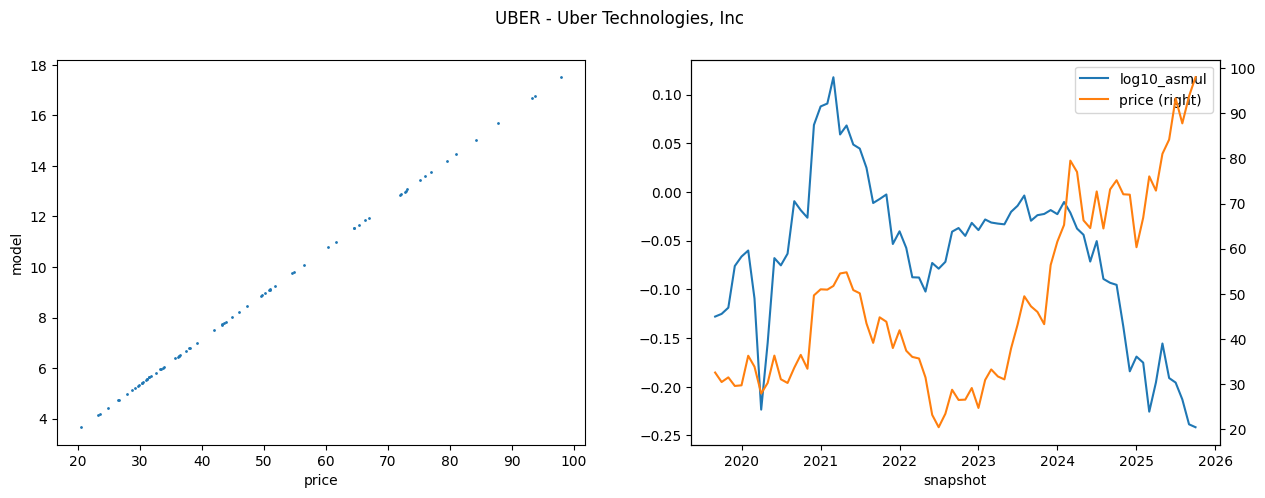

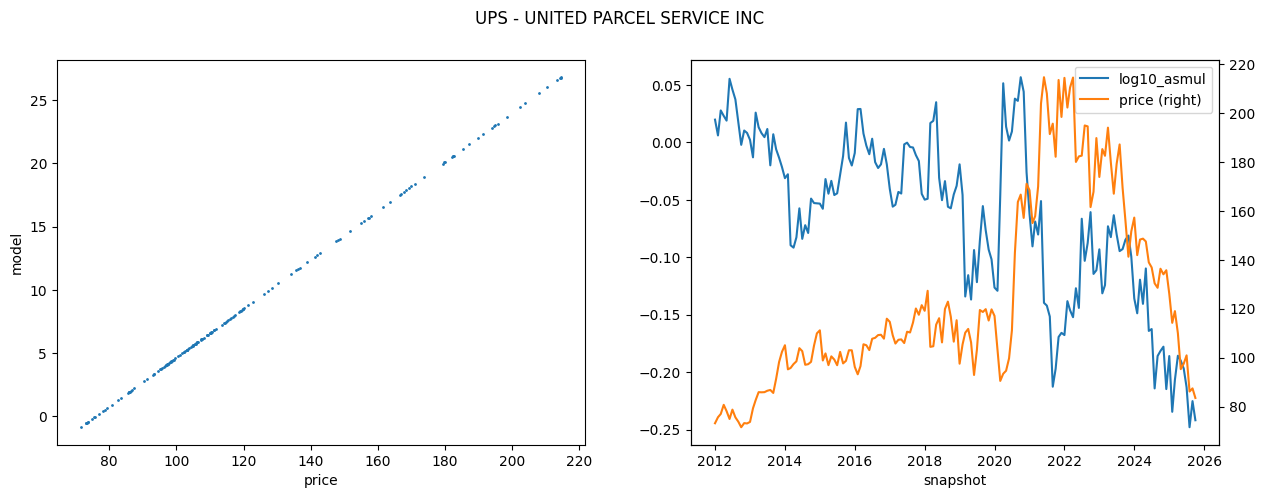

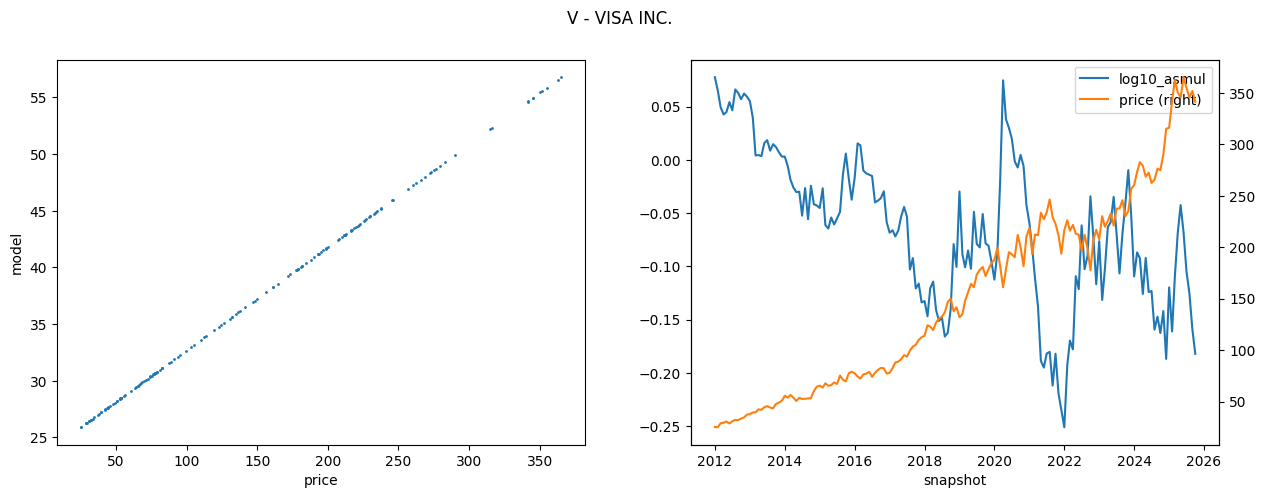

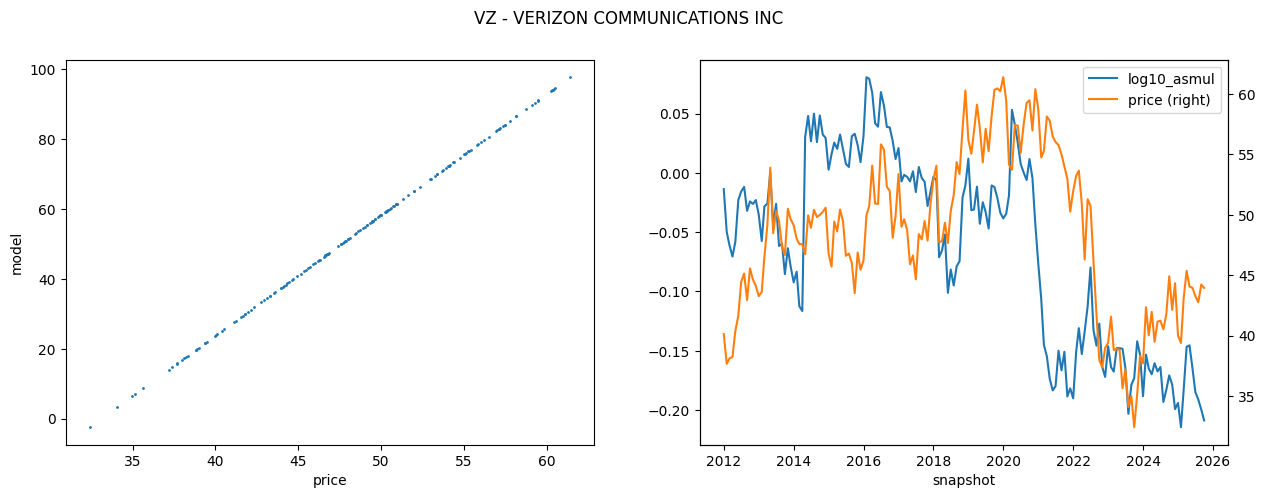

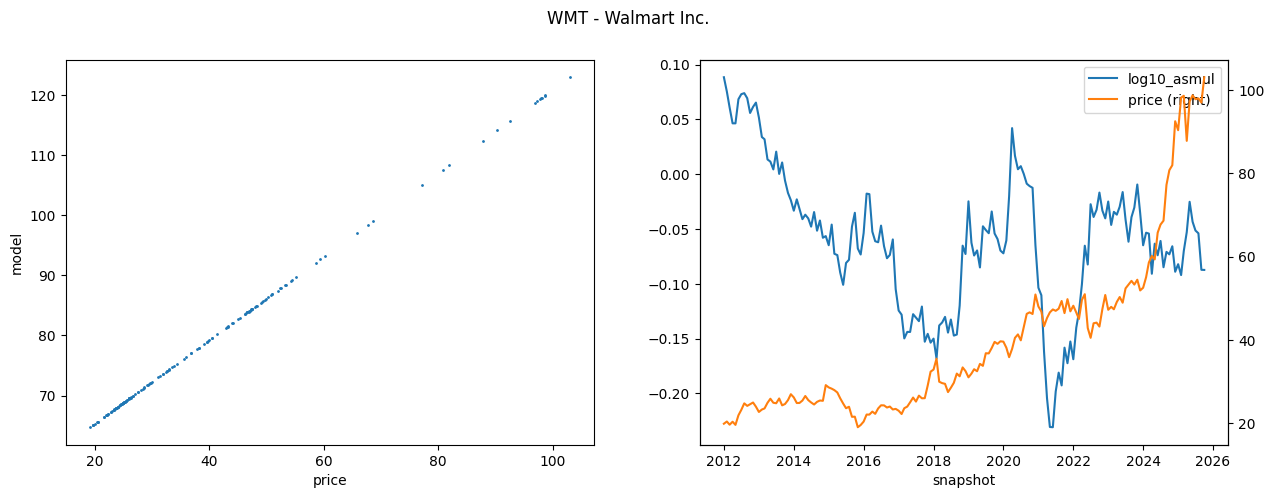

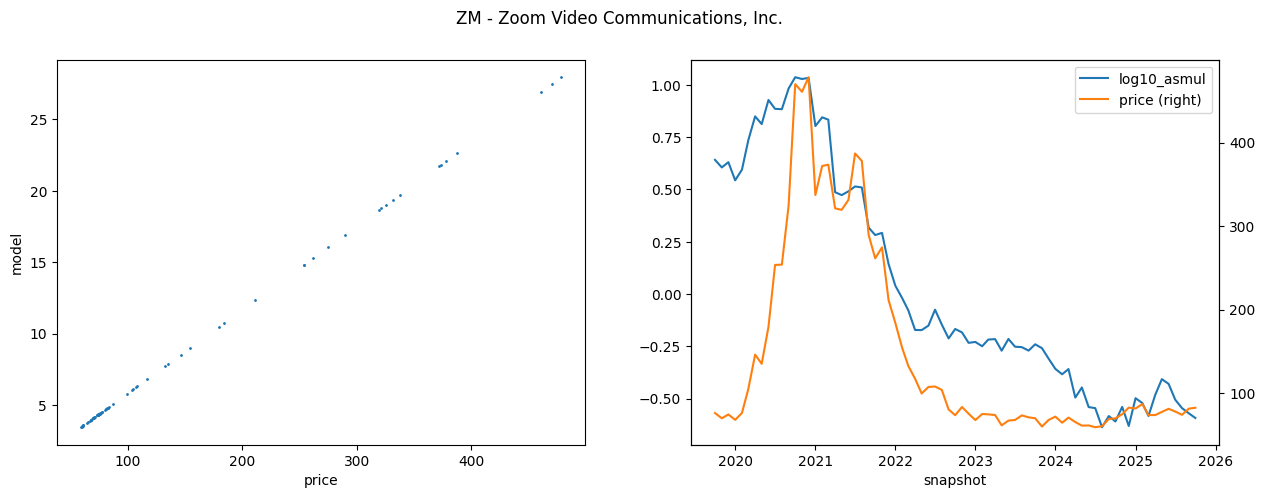

ticker     Assets  Liabilities  \
snapshot   cik        date                                        
2025-10-11 0000320193 2025-06-28   AAPL 331.495000   265.665000   
           0000796343 2025-08-29   ADBE  28.754000    16.984000   
           0000769397 2025-07-31   ADSK  10.856000     8.141000   
           0000002488 2025-06-28    AMD  74.820000    15.155000   
           0001018724 2025-06-30   AMZN 682.170000   348.395000   
           0001655210 2025-06-28   BYND   0.691741     1.368764   
           0000018230 2025-06-30    CAT  90.325000    71.662000   
           0000909832 2025-08-31   COST  77.099000    47.935000   
           0001743759 2025-06-30   CRSR   1.221880     0.617983   
           0000858877 2025-07-26   CSCO 122.291000    75.448000   
           0001744489 2025-06-28    DIS 196.612000    87.467000   
           0001463101 2025-06-30   ENPH   3.178789     2.298152   
           0000037996 2025-06-30      F 292.725000   247.668000   
           0001048911 2025-08-31    FDX  88.416000    60.645000   
           0001274494 2025-06-30   FSLR  12.858044     4.311914   
           0001467858 2025-06-30     GM 289.384000   223.021000   
           0001326380 2025-08-02    GME  10.341100     5.164700   
           0001652044 2025-06-30   GOOG 502.053000   139.137000   
           0001500435 2025-06-30   GPRO   0.438990     0.341075   
           0000051143 2025-06-30    IBM 148.585000   121.076000   
           0001110803 2025-06-29   ILMN   6.087000     3.829000   
           0000050863 2025-06-28   INTC 192.520000    94.637000   
           0001159167 2025-06-28   IRBT   0.480320     0.488012   
           0000200406 2025-06-29    JNJ 193.389000   114.916000   
           0001759509 2025-06-30   LYFT   5.369367     4.636691   
           0001326801 2025-06-30   META 294.744000    99.674000   
           0000066740 2025-06-30    MMM  37.989000    33.699000   
           0001682852 2025-06-30   MRNA  12.010000     2.611000   
           0000789019 2025-06-30   MSFT 619.003000   275.524000   
           0000723125 2025-08-28     MU  82.798000    28.633000   
           0001065280 2025-06-30   NFLX  53.099664    28.147765   
           0000320187 2025-08-31    NKE  37.334000    23.866000   
           0001045810 2025-07-27   NVDA 140.740000    40.609000   
           0001341439 2025-08-31   ORCL 180.449000   156.295000   
           0001506293 2025-06-30   PINS   5.402987     0.591034   
           0001321655 2025-06-30   PLTR   7.365688     1.436787   
           0001639825 2025-06-30   PTON   2.125300     2.539100   
           0001633917 2025-06-30   PYPL  79.777000    59.576000   
           0001428439 2025-06-30   ROKU   4.281955     1.691403   
           0000732717 2025-06-30      T 405.491000   284.097000   
           0001477449 2025-06-30   TDOC   2.894004     1.471865   
           0000027419 2025-08-02    TGT  57.851000    42.431000   
           0001318605 2025-06-30   TSLA 128.567000    51.253000   
           0001543151 2025-06-30   UBER  55.982000    33.384000   
           0001090727 2025-06-30    UPS  70.923000    55.173000   
           0001403161 2025-06-30      V 100.024000    61.360000   
           0000732712 2025-06-30     VZ 383.285000   278.924000   
           0000104169 2025-07-31    WMT 270.837000   180.727000   
           0001585521 2025-07-31     ZM  11.044063     2.093986   

                                  NetCashOperating_ttm  price    asmul  \
snapshot   cik        date                                               
2025-10-11 0000320193 2025-06-28            108.565000    NaN 0.734194   
           0000796343 2025-08-29              9.792000    NaN 0.397753   
           0000769397 2025-07-31              1.925000    NaN 1.171561   
           0000002488 2025-06-28              4.877000    NaN 0.588448   
           0001018724 2025-06-30            206.735833    NaN 0.370195   
           0001655210 2025-06-28             -0.110354    NaN 2.415056   
           0000018230 2

In [17]:
test_tickers = ["AAPL","ADBE","ADSK","AMD","AMZN","BYND","CAT","COST","CRSR","CSCO",
                "DIS","ENPH","F","FDX","FSLR","GM","GME","GOOG","GPRO","IBM","ILMN","INTC","IRBT","JNJ","LYFT",
                "META","MMM","MRNA","MSFT","MU","NFLX","NKE","NVDA","ORCL","PINS","PLTR","PTON","PYPL","ROKU",
                "T","TDOC","TGT","TLRY","TSLA","UBER","UPS","V","VZ","WMT","ZM"]
def test_plot(a_group):
    (ticker, cik), df = a_group
    try:
        name = tickers.loc[cik]['name']
    except:
        name = ""
    plot_data = df[['asmul','model',ml_label]].copy().loc[(slice(None),cik),:].dropna()
    plot_data['log10_asmul'] = np.log10(plot_data['asmul'])
    plot_data = plot_data.reset_index().set_index('snapshot')
    plot_data = plot_data[plot_data['price']>0]

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(f"{ticker} - {name}")
    fig.set_size_inches(15,5)
    plot_data.plot.scatter(x=ml_label,y='model',s=1,ax=ax1)
    plot_data['log10_asmul'].plot(ax=ax2,legend=True)
    plot_data[ml_label].plot(ax=ax2,secondary_y=True,legend=True,grid=False)
    plt.show()

    return df.tail(1)
pd.concat(list(map(test_plot, result[result['ticker'].isin(test_tickers)].groupby(by=['ticker','cik']))))

In [18]:
print('Done without errors')

Done without errors
